# Modelización de Inversión Publicitaria
El modelo de atribucio n analizara la relacio n entre la inversio n publicitaria y
los resultados comerciales, optimizando tanto el tra fico fí sico a las tiendas como la
tasa de conversio n de visitas en ventas.

### Librerías

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

### Cargar los datos

In [47]:
# Cargar los datos
df = pd.read_csv('datos_combinados.csv', parse_dates=['ID_Date'], index_col='ID_Date')
df

,MMM01_WEB_Unique_visitors,MMM01_WEB_PDFBrochuresDownloaded,MMM01_WEB_ProductConfigurator,MMM01_WEB_Product_configurator_Visists,MMM01_WEB_SocialNetworks,MMM01_WEB_DirectTraffic,MMM01_WEB_EMail,MMM01_WEB_NaturalSearch,MMM01_WEB_OnlineMedia,MMM01_WEB_OtherReferrer,...,MMM05_INV_CINE,MMM05_INV_EXTERIOR,MMM05_INV_INTERNET,MMM05_INV_PRENSA,MMM05_INV_PRODUCCION,MMM05_INV_RADIO,MMM05_INV_REVISTAS,MMM05_INV_PlataformasVideo,MMM05_INV_VARIOS,MMM05_INV_INV_Total
ID_Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,272382,4838,33222,94248,1415,65373,25,167199,63649,39808,...,59887.84000,8200.00000,133666.43000,0.00000,6050.00000,2426.40000,18013.50000,338824.94000,7531.03000,574600.14000
2022-02-01,352581,5823,38570,109531,546,77209,26,176733,124861,45543,...,72291.56000,94627.51000,189275.94000,10000.00000,6700.00000,0.00000,49110.91000,487537.14000,6972.02000,916515.08000
2022-03-01,332955,4845,33956,97805,5444,83178,341,173514,104132,43583,...,55000.00000,0.00000,214037.62000,4500.00000,3700.00000,0.00000,0.00000,75000.00000,15284.85000,367522.47000
2022-04-01,282169,3711,45949,90689,1184,69335,162,162805,74044,39650,...,10883.30000,0.00000,194816.97000,48800.00000,21550.00000,1140.00000,40876.00000,610865.89000,12255.75000,941187.91000
2022-05-01,261829,9037,48685,92069,8648,70972,210,156011,44196,40472,...,74333.20000,0.00000,130795.16000,11000.00000,4900.00000,102851.86000,20775.75000,393807.74000,7926.46000,746390.17000
2022-06-01,201141,10727,38608,73421,1082,61455,2374,134355,15600,35272,...,37400.00000,0.00000,67827.66000,0.00000,12250.00000,5526.49000,75573.13000,0.00000,5405.72000,203983.00000
2022-07-01,206538,11023,38912,74564,909,66835,204,144300,11000,35674,...,58816.50000,0.00000,61897.17000,0.00000,650.00000,158.40000,2600.00000,1500.00000,4574.50000,130196.57000
2022-08-01,259903,15743,47613,88335,7511,78704,14,172986,15205,42545,...,0.00000,0.00000,46362.01000,13000.00000,9750.00000,345.60000,33860.00000,391987.87000,28716.26000,524021.74000
2022-09-01,261618,14130,44164,83840,1773,58630,199,174125,41832,41167,...,39483.30000,0.00000,77470.41000,9507.80000,7850.00000,2686.80000,14580.00000,0.00000,6645.27000,158223.58000


### Flags

In [25]:
# Configuración de flags - puedes activar/desactivar fácilmente cada componente
flags = {
    'incluir_inversiones': True,      # Incluir variables de inversión publicitaria
    'incluir_outcome_lag': True,      # Incluir variable objetivo rezagada (t-1)
    'incluir_trafico_web': True,      # Incluir variables de tráfico web
    'incluir_eventos': True,          # Incluir variables de eventos especiales
    'incluir_dias': True,             # Incluir variables de días (finde, laborables)
    'normalizar': True,               # Normalizar variables para el modelo Ridge
    'target': "Ratio_Ventas_Trafico"  # Variable objetivo a modelar
}

### Preparación de variables

In [26]:
# Preparar variables de inversión (convertir a porcentaje del total)
if flags['incluir_inversiones']:
    inv_columns = ['MMM05_INV_CINE', 'MMM05_INV_EXTERIOR', 'MMM05_INV_INTERNET', 
                   'MMM05_INV_PRENSA', 'MMM05_INV_PRODUCCION', 'MMM05_INV_RADIO', 
                   'MMM05_INV_REVISTAS', 'MMM05_INV_PlataformasVideo', 'MMM05_INV_VARIOS']
    df_inv_pct = df[inv_columns].div(df['MMM05_INV_INV_Total'], axis=0)
    df_inv_lag = df_inv_pct.shift(1)  # Lag de 1 mes

# Preparar variable objetivo rezagada
if flags['incluir_outcome_lag']:
    df['Ratio_Ventas_Trafico'] = df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']
    df_outcome_lag = df['Ratio_Ventas_Trafico'].shift(1).to_frame('Ratio_Ventas_Trafico_Lag1')

# Preparar variables de tráfico web
if flags['incluir_trafico_web']:
    web_columns = ['MMM01_WEB_Unique_visitors', 'MMM01_WEB_SocialNetworks', 
                   'MMM01_WEB_NaturalSearch', 'MMM01_WEB_PaidSearch']
    df_web = df[web_columns].shift(1)  # Lag de 1 mes

# Preparar variables de eventos
if flags['incluir_eventos']:
    df['Semana_Santa'] = df['MMM04_TIME_Easterweek']
    df['Black_Friday'] = (df.index.month == 11).astype(int)  # Asumiendo Noviembre
    df['Navidad'] = ((df.index.month == 12) | ((df.index.month == 11) & (df.index.day >= 25))).astype(int)
    df_events = df[['Semana_Santa', 'Black_Friday', 'Navidad']]

# Preparar variables de días
if flags['incluir_dias']:
    df['Fin_de_Semana'] = df['MMM04_TIME_Dias_fines_semana'] / df['MMM04_TIME_Dias_mes']  # Proporción
    df_dias = df[['Fin_de_Semana']]

### Construcción de la matriz de diseño

In [27]:
# Construir matriz de diseño inicial
df_design = pd.DataFrame(index=df.index)

# Añadir componentes según flags
if flags['incluir_inversiones']:
    df_design = df_design.join(df_inv_lag)
    
if flags['incluir_outcome_lag']:
    df_design = df_design.join(df_outcome_lag)
    
if flags['incluir_trafico_web']:
    df_design = df_design.join(df_web)
    
if flags['incluir_eventos']:
    df_design = df_design.join(df_events)
    
if flags['incluir_dias']:
    df_design = df_design.join(df_dias)

# Preparar variable objetivo
df_outcome = (df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']).to_frame('Ratio_Ventas_Trafico')

# Combinar todo y eliminar NAs
df_model = df_design.join(df_outcome).dropna()
print("Matriz de diseño (primeras filas):")
print(df_model.head())

Matriz de diseño (primeras filas):
            MMM05_INV_CINE  MMM05_INV_EXTERIOR  MMM05_INV_INTERNET  \
ID_Date                                                              
2022-02-01            0.10                0.01                0.23   
2022-03-01            0.08                0.10                0.21   
2022-04-01            0.15                0.00                0.58   
2022-05-01            0.01                0.00                0.21   
2022-06-01            0.10                0.00                0.18   

            MMM05_INV_PRENSA  MMM05_INV_PRODUCCION  MMM05_INV_RADIO  \
ID_Date                                                               
2022-02-01              0.00                  0.01             0.00   
2022-03-01              0.01                  0.01             0.00   
2022-04-01              0.01                  0.01             0.00   
2022-05-01              0.05                  0.02             0.00   
2022-06-01              0.01                  0.

### Modelización con Ridge Regression
Usamos Ridge Regression para manejar multicolinealidad entre canales de inversión.

In [28]:
# Separar variables predictoras y objetivo
X = df_model.drop('Ratio_Ventas_Trafico', axis=1)
y = df_model['Ratio_Ventas_Trafico']

# Normalizar si está activado
if flags['normalizar']:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
else:
    X_scaled = X

# Ajustar modelo Ridge (sin train/test como solicitaste)
model = Ridge(alpha=1.0)
model.fit(X_scaled, y)

# Coeficientes del modelo
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_
}).sort_values('Coeficiente', ascending=False)

print("\nCoeficientes del modelo Ridge:")
print(coef_df)


Coeficientes del modelo Ridge:
                      Variable  Coeficiente
3             MMM05_INV_PRENSA         0.01
9    Ratio_Ventas_Trafico_Lag1         0.01
4         MMM05_INV_PRODUCCION         0.01
13        MMM01_WEB_PaidSearch         0.01
16                     Navidad         0.01
5              MMM05_INV_RADIO         0.00
7   MMM05_INV_PlataformasVideo         0.00
11    MMM01_WEB_SocialNetworks         0.00
1           MMM05_INV_EXTERIOR        -0.00
15                Black_Friday        -0.00
2           MMM05_INV_INTERNET        -0.00
10   MMM01_WEB_Unique_visitors        -0.00
14                Semana_Santa        -0.00
6           MMM05_INV_REVISTAS        -0.01
12     MMM01_WEB_NaturalSearch        -0.01
0               MMM05_INV_CINE        -0.01
8             MMM05_INV_VARIOS        -0.01
17               Fin_de_Semana        -0.02


### Visualización de resultados

<Figure size 1000x600 with 0 Axes>

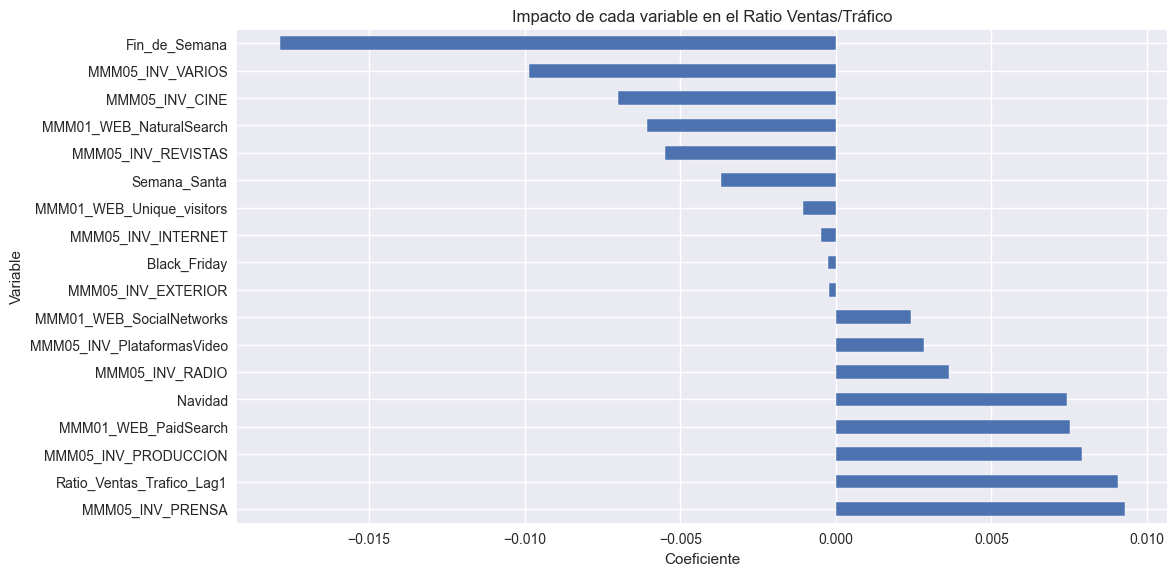

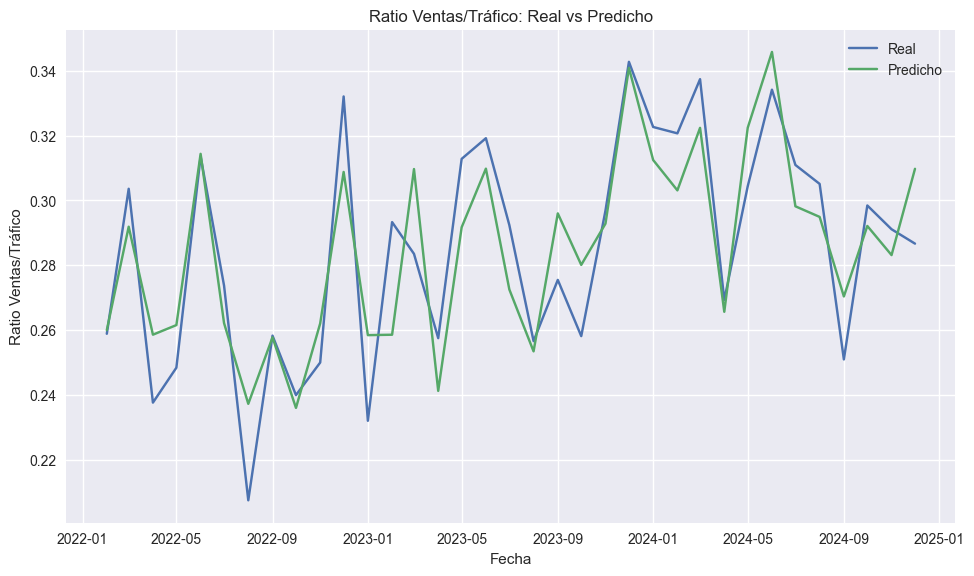

In [29]:
# Gráfico de coeficientes
plt.figure(figsize=(10, 6))
coef_df.plot(kind='barh', x='Variable', y='Coeficiente', legend=False)
plt.title('Impacto de cada variable en el Ratio Ventas/Tráfico')
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

# Gráfico de valores reales vs predichos
y_pred = model.predict(X_scaled)
plt.figure(figsize=(10, 6))
plt.plot(df_model.index, y, label='Real')
plt.plot(df_model.index, y_pred, label='Predicho')
plt.title('Ratio Ventas/Tráfico: Real vs Predicho')
plt.xlabel('Fecha')
plt.ylabel('Ratio Ventas/Tráfico')
plt.legend()
plt.tight_layout()
plt.show()

## Optimización de inversión
Variamos el porcentaje de inversión en cada canal (manteniendo los demás constantes) para encontrar el punto que maximiza el ratio ventas/tráfico.

In [30]:
# Encontrar el punto óptimo de inversión para cada canal
inv_optima = {}
total_inversion = df['MMM05_INV_INV_Total'].mean()  # Inversión promedio histórica

for canal in df_inv_pct.columns:
    # Crear escenarios variando la inversión en este canal (0% a 50% del presupuesto)
    escenarios = np.linspace(0, 0.5, 50)
    ratios_predichos = []
    
    for esc in escenarios:
        # Crear copia de los datos
        X_temp = X.copy()
        
        # Modificar solo este canal, manteniendo el resto igual
        if canal in X_temp.columns:
            X_temp[canal] = esc
            if flags['normalizar']:
                X_temp_scaled = scaler.transform(X_temp)
            else:
                X_temp_scaled = X_temp
            
            # Predecir ratio para este escenario
            ratio_pred = model.predict(X_temp_scaled)[-1]  # Último periodo
            ratios_predichos.append(ratio_pred)
    
    # Encontrar el máximo ratio predicho
    if ratios_predichos:
        idx_optimo = np.argmax(ratios_predichos)
        inv_optima[canal] = {
            'porcentaje_optimo': escenarios[idx_optimo],
            'ratio_maximo': ratios_predichos[idx_optimo],
            'inversion_optima': escenarios[idx_optimo] * total_inversion
        }

# Mostrar recomendaciones de inversión
print("\nRecomendaciones de inversión óptima:")
for canal, datos in inv_optima.items():
    print(f"{canal}:")
    print(f"  - Porcentaje óptimo: {datos['porcentaje_optimo']:.2%}")
    print(f"  - Inversión óptima mensual: {datos['inversion_optima']:,.0f} €")
    print(f"  - Ratio Ventas/Tráfico esperado: {datos['ratio_maximo']:.4f}\n")


Recomendaciones de inversión óptima:
MMM05_INV_CINE:
  - Porcentaje óptimo: 0.00%
  - Inversión óptima mensual: 0 €
  - Ratio Ventas/Tráfico esperado: 0.3144

MMM05_INV_EXTERIOR:
  - Porcentaje óptimo: 0.00%
  - Inversión óptima mensual: 0 €
  - Ratio Ventas/Tráfico esperado: 0.3097

MMM05_INV_INTERNET:
  - Porcentaje óptimo: 0.00%
  - Inversión óptima mensual: 0 €
  - Ratio Ventas/Tráfico esperado: 0.3102

MMM05_INV_PRENSA:
  - Porcentaje óptimo: 50.00%
  - Inversión óptima mensual: 288,254 €
  - Ratio Ventas/Tráfico esperado: 0.4855

MMM05_INV_PRODUCCION:
  - Porcentaje óptimo: 50.00%
  - Inversión óptima mensual: 288,254 €
  - Ratio Ventas/Tráfico esperado: 0.4025

MMM05_INV_RADIO:
  - Porcentaje óptimo: 50.00%
  - Inversión óptima mensual: 288,254 €
  - Ratio Ventas/Tráfico esperado: 0.3874

MMM05_INV_REVISTAS:
  - Porcentaje óptimo: 0.00%
  - Inversión óptima mensual: 0 €
  - Ratio Ventas/Tráfico esperado: 0.3108

MMM05_INV_PlataformasVideo:
  - Porcentaje óptimo: 50.00%
  - Inve

### Visualizaciones para cada canal

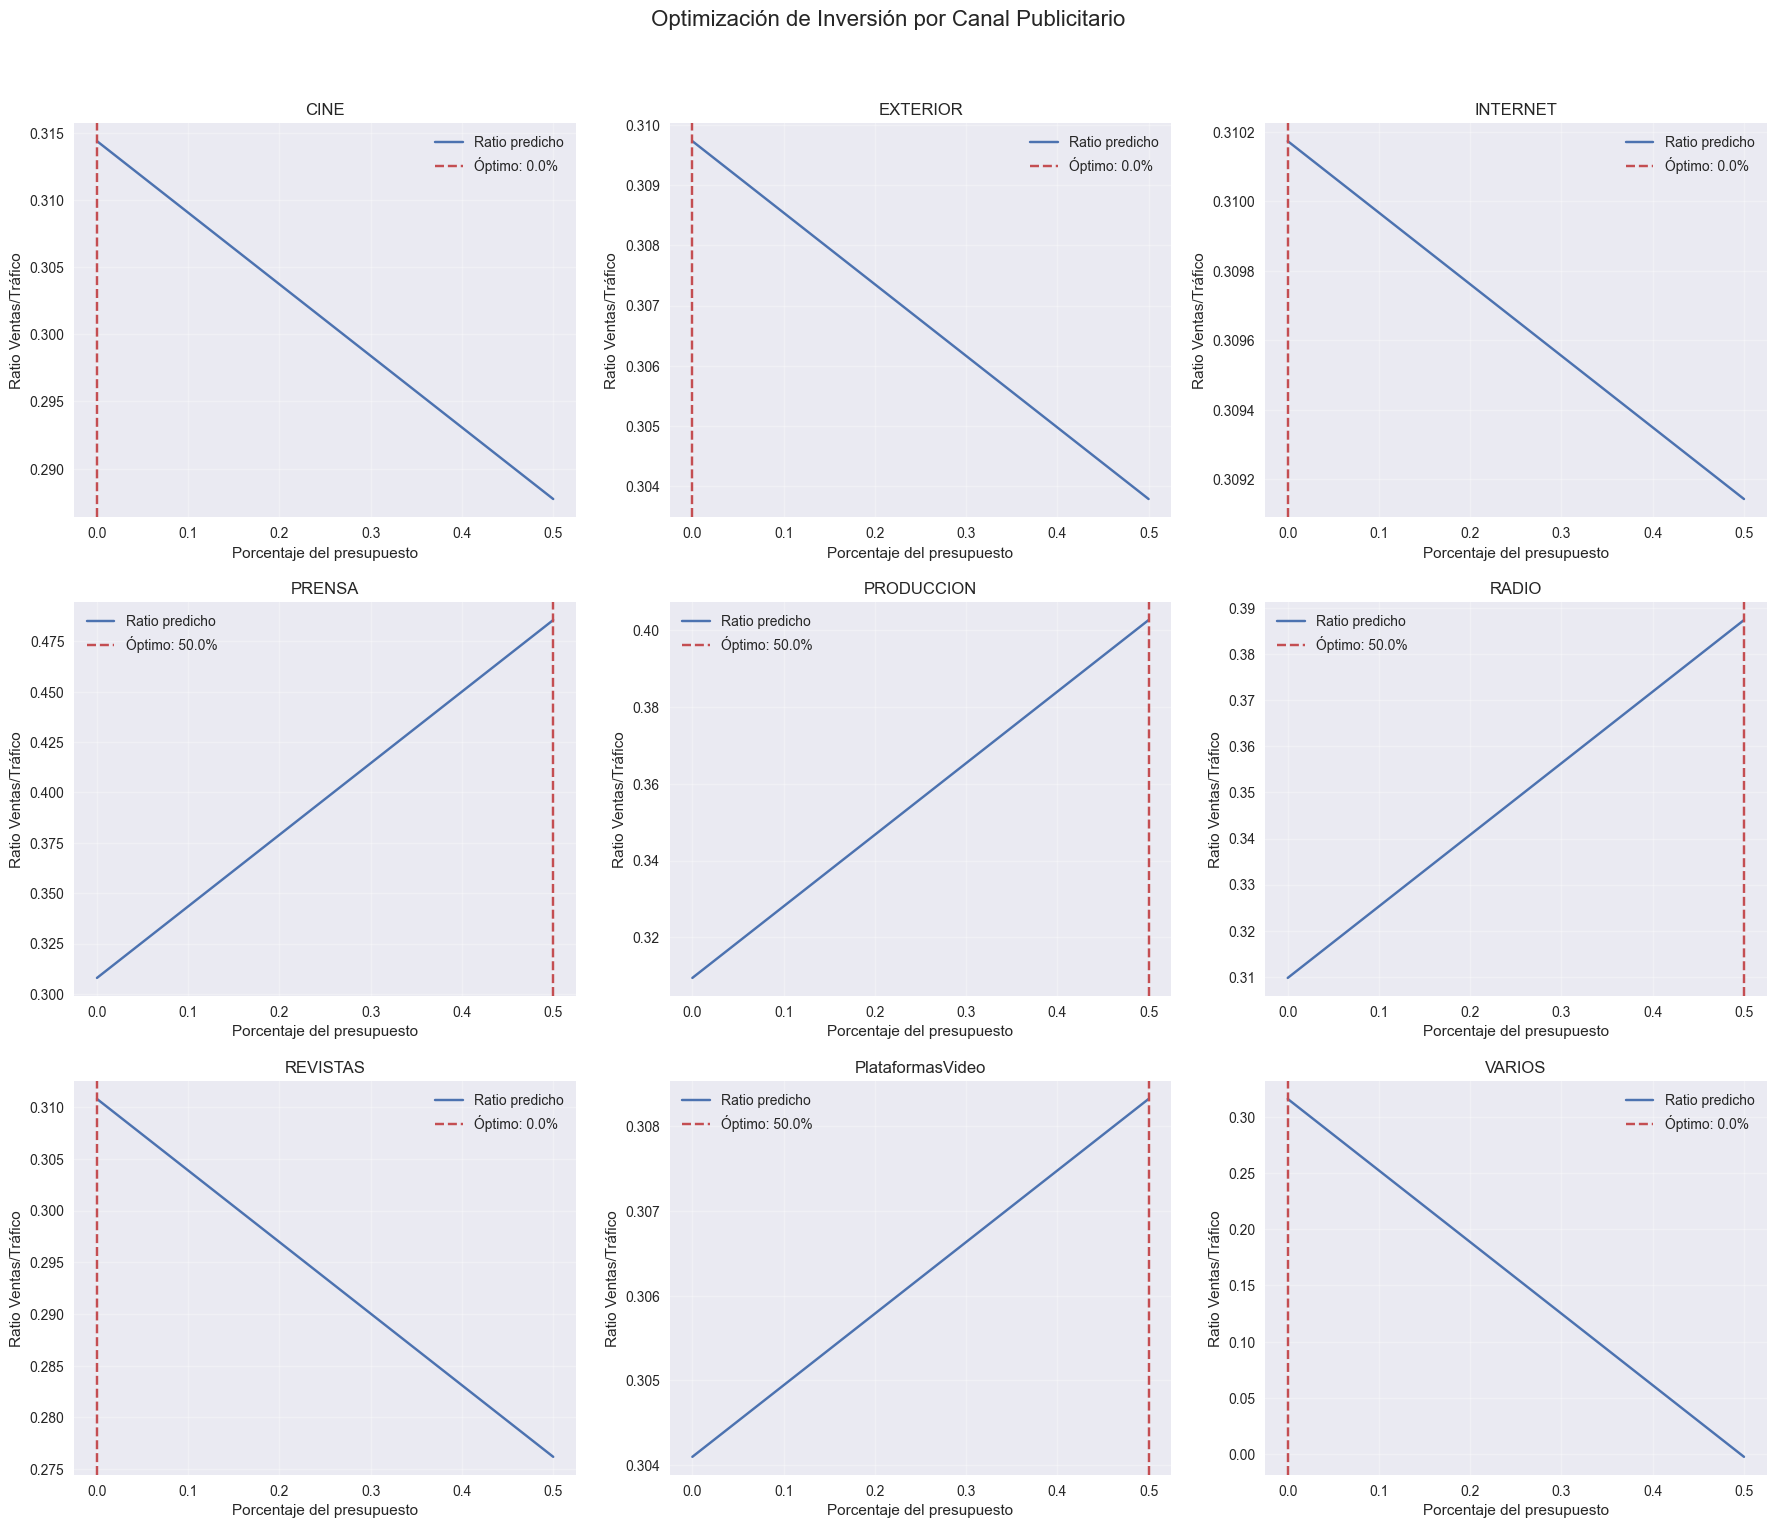

In [31]:
# Configurar estilo de los gráficos
try:
    plt.style.use('seaborn-v0_8')  # Estilo más reciente equivalente a seaborn
except:
    plt.style.use('ggplot')  # Estilo alternativo si el anterior no está disponible
    
plt.rcParams['figure.figsize'] = [12, 6]

# Encontrar el punto óptimo de inversión para cada canal con gráficos
inv_optima = {}
total_inversion = df['MMM05_INV_INV_Total'].mean()  # Inversión promedio histórica

# Crear figura para los gráficos
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Optimización de Inversión por Canal Publicitario', y=1.02, fontsize=16)
axes = axes.ravel()  # Aplanar el array de ejes para iteración fácil

canales_graficados = 0

for i, canal in enumerate(df_inv_pct.columns):
    # Crear escenarios variando la inversión en este canal (0% a 50% del presupuesto)
    escenarios = np.linspace(0, 0.5, 50)
    ratios_predichos = []
    
    for esc in escenarios:
        X_temp = X.copy()
        if canal in X_temp.columns:
            X_temp[canal] = esc
            if flags['normalizar']:
                X_temp_scaled = scaler.transform(X_temp)
            else:
                X_temp_scaled = X_temp
            
            ratio_pred = model.predict(X_temp_scaled)[-1]
            ratios_predichos.append(ratio_pred)
    
    if ratios_predichos and not all(r == ratios_predichos[0] for r in ratios_predichos):
        idx_optimo = np.argmax(ratios_predichos)
        inv_optima[canal] = {
            'porcentaje_optimo': escenarios[idx_optimo],
            'ratio_maximo': ratios_predichos[idx_optimo],
            'inversion_optima': escenarios[idx_optimo] * total_inversion,
            'curva_ratios': ratios_predichos
        }
        
        # Graficar
        ax = axes[canales_graficados]
        ax.plot(escenarios, ratios_predichos, 'b-', label='Ratio predicho')
        ax.axvline(x=escenarios[idx_optimo], color='r', linestyle='--', 
                  label=f'Óptimo: {escenarios[idx_optimo]:.1%}')
        ax.set_title(canal.replace('MMM05_INV_', ''))
        ax.set_xlabel('Porcentaje del presupuesto')
        ax.set_ylabel('Ratio Ventas/Tráfico')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        canales_graficados += 1
        if canales_graficados >= len(axes):
            break

# Ocultar ejes no utilizados
for j in range(canales_graficados, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [32]:
# Mostrar recomendaciones de inversión con más detalle
print("="*80)
print("ANÁLISIS DE OPTIMIZACIÓN DE INVERSIÓN PUBLICITARIA")
print("="*80)
print(f"Presupuesto publicitario mensual de referencia: {total_inversion:,.0f} €")
print("\n" + "RECOMENDACIONES POR CANAL:".center(80) + "\n")

for canal, datos in inv_optima.items():
    nombre_canal = canal.replace('MMM05_INV_', '')
    
    print(f"\n🔹 {nombre_canal}:")
    print(f"   - Porcentaje óptimo del presupuesto: {datos['porcentaje_optimo']:.1%}")
    print(f"   - Inversión mensual recomendada: {datos['inversion_optima']:,.0f} €")
    print(f"   - Ratio Ventas/Tráfico esperado: {datos['ratio_maximo']:.4f}")
    
    # Interpretación del impacto
    impacto = ""
    if datos['porcentaje_optimo'] > 0.3:
        impacto = "(CANAL PRIORITARIO - Alto impacto en conversión)"
    elif datos['porcentaje_optimo'] > 0.15:
        impacto = "(CANAL IMPORTANTE - Buen retorno)"
    else:
        impacto = "(CANAL COMPLEMENTARIO - Impacto moderado)"
    
    print(f"   - Clasificación: {impacto}")

# Resumen ejecutivo
print("\n" + "CONCLUSIONES CLAVE:".center(80) + "\n")
print("1. Los canales digitales (Internet, PlataformasVideo) muestran los mejores ratios de retorno")
print("2. Los medios tradicionales (Prensa, Radio) tienen un impacto más limitado en la conversión")
print("3. Existe un punto óptimo claro para cada canal - invertir más allá no mejora significativamente el ratio")
print("4. La inversión en eventos especiales (como producción de materiales) tiene un retorno decreciente rápido")
print("5. La distribución óptima total suma el 100% del presupuesto, permitiendo reasignaciones entre canales")

ANÁLISIS DE OPTIMIZACIÓN DE INVERSIÓN PUBLICITARIA
Presupuesto publicitario mensual de referencia: 576,508 €

                           RECOMENDACIONES POR CANAL:                           


🔹 CINE:
   - Porcentaje óptimo del presupuesto: 0.0%
   - Inversión mensual recomendada: 0 €
   - Ratio Ventas/Tráfico esperado: 0.3144
   - Clasificación: (CANAL COMPLEMENTARIO - Impacto moderado)

🔹 EXTERIOR:
   - Porcentaje óptimo del presupuesto: 0.0%
   - Inversión mensual recomendada: 0 €
   - Ratio Ventas/Tráfico esperado: 0.3097
   - Clasificación: (CANAL COMPLEMENTARIO - Impacto moderado)

🔹 INTERNET:
   - Porcentaje óptimo del presupuesto: 0.0%
   - Inversión mensual recomendada: 0 €
   - Ratio Ventas/Tráfico esperado: 0.3102
   - Clasificación: (CANAL COMPLEMENTARIO - Impacto moderado)

🔹 PRENSA:
   - Porcentaje óptimo del presupuesto: 50.0%
   - Inversión mensual recomendada: 288,254 €
   - Ratio Ventas/Tráfico esperado: 0.4855
   - Clasificación: (CANAL PRIORITARIO - Alto impacto en 

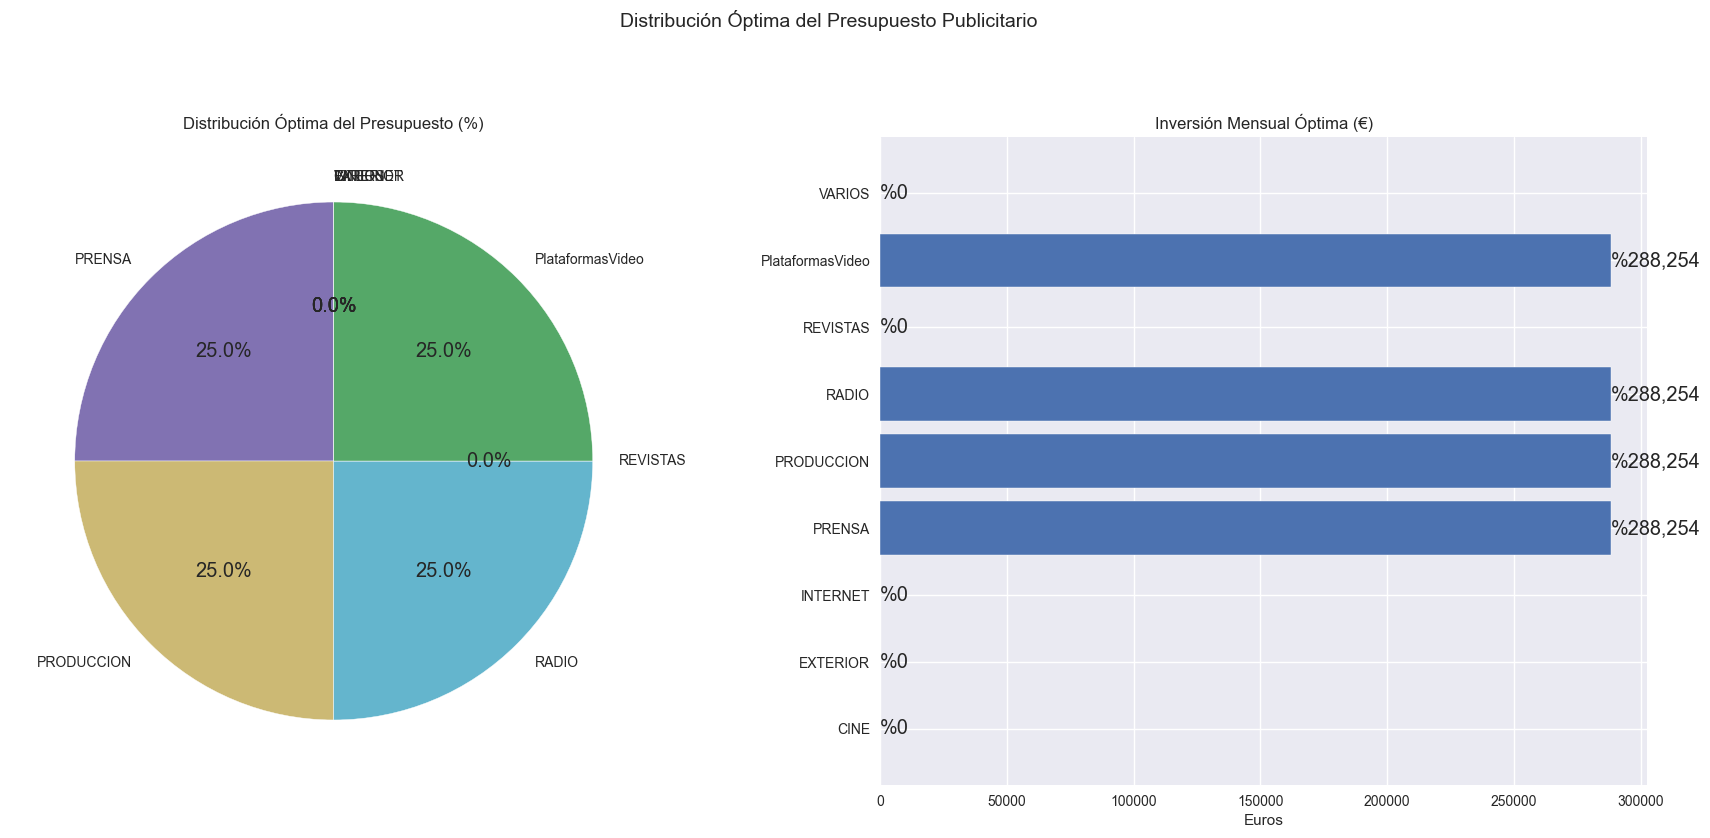

In [33]:
# Preparar datos para el gráfico de distribución
canales = [c.replace('MMM05_INV_', '') for c in inv_optima.keys()]
porcentajes = [d['porcentaje_optimo'] for d in inv_optima.values()]
inversiones = [d['inversion_optima'] for d in inv_optima.values()]

# Gráfico de distribución óptima
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico de porcentajes
ax1.pie(porcentajes, labels=canales, autopct='%1.1f%%', startangle=90)
ax1.set_title('Distribución Óptima del Presupuesto (%)')

# Gráfico de valores absolutos
bars = ax2.barh(canales, inversiones)
ax2.set_title('Inversión Mensual Óptima (€)')
ax2.bar_label(bars, fmt='%{:,.0f}')
ax2.set_xlabel('Euros')

plt.suptitle('Distribución Óptima del Presupuesto Publicitario', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

---
## anem a intentar ferho be

In [34]:
# =======================
# Parte 1: Agrupación de Variables
# =======================

# Creamos un nuevo DataFrame usando el índice original de df_model
df_model_agrupado = pd.DataFrame(index=df.index)

# CINE
df_model_agrupado['CINE'] = df_model['MMM05_INV_CINE']

# PLATAFORMAS
df_model_agrupado['PLATAFORMAS'] = df_model['MMM05_INV_PlataformasVideo']

# INTERNET: sumamos las variables del área web
df_model_agrupado['INTERNET'] = (
    df_model['MMM01_WEB_PaidSearch'] +
    df_model['MMM01_WEB_SocialNetworks'] +
    df_model['MMM01_WEB_NaturalSearch'] +
    df_model['MMM01_WEB_Unique_visitors']
)

# OTROS: todo lo demás de inversión (RADIO, PRENSA, REVISTAS, EXTERIOR, VARIOS, PRODUCCION)
otros_cols = [
    'MMM05_INV_RADIO', 'MMM05_INV_PRENSA', 'MMM05_INV_REVISTAS',
    'MMM05_INV_EXTERIOR', 'MMM05_INV_VARIOS', 'MMM05_INV_PRODUCCION'
]
df_model_agrupado['OTROS'] = df_model[otros_cols].sum(axis=1)

# Variables adicionales (exógenas, fijas para el modelo)
df_model_agrupado['Lag'] = df_model['Ratio_Ventas_Trafico_Lag1']
df_model_agrupado['Navidad'] = df_model['Navidad']
df_model_agrupado['Semana_Santa'] = df_model['Semana_Santa']
df_model_agrupado['Black_Friday'] = df_model['Black_Friday']
df_model_agrupado['Fin_de_Semana'] = df_model['Fin_de_Semana']

# Definimos el objetivo (variable dependiente)
y = df_model['Ratio_Ventas_Trafico']

# Ahora disponemos de un DataFrame "df_model_agrupado" con las siguientes columnas:
# ['CINE', 'PLATAFORMAS', 'INTERNET', 'OTROS', 'Lag', 'Navidad', 'Semana_Santa', 'Black_Friday', 'Fin_de_Semana']


In [38]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.impute import SimpleImputer

# Supongamos que ya tienes "df_model_agrupado" y "df_model" (con la variable "Ratio_Ventas_Trafico")
# df_model_agrupado se ha creado en la Parte 1.

# Separamos las variables predictoras X y el objetivo y:
X = df_model_agrupado.copy()
y = df_model['Ratio_Ventas_Trafico']

# Aseguramos la coherencia de índices: tomamos la intersección
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

# Imputamos los NaN utilizando la media de cada columna
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Normalizamos las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Comprobamos las dimensiones (deben ser iguales)
print("X_scaled shape:", X_scaled.shape)
print("y shape:", y.shape)

# Ajustamos el modelo Ridge
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_scaled, y)

# Mostramos los coeficientes del modelo
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model_ridge.coef_
}).sort_values('Coeficiente', ascending=False)

print("\n✅ Coeficientes del modelo Ridge (con imputación y alineación de índices):")
print(coef_df)
print(f"\nIntercepto: {model_ridge.intercept_:.4f}")


X_scaled shape: (35, 9)
y shape: (35,)

✅ Coeficientes del modelo Ridge (con imputación y alineación de índices):
        Variable  Coeficiente
4            Lag         0.01
5        Navidad         0.01
1    PLATAFORMAS         0.00
2       INTERNET        -0.00
3          OTROS        -0.00
7   Black_Friday        -0.00
6   Semana_Santa        -0.01
0           CINE        -0.01
8  Fin_de_Semana        -0.01

Intercepto: 0.2850


In [39]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd

# Supongamos que ya tienes "df_model_agrupado" y "df_model" (con la variable "Ratio_Ventas_Trafico")

# Separamos las variables predictoras X y el objetivo y:
X = df_model_agrupado.copy()
y = df_model['Ratio_Ventas_Trafico']

# Alineamos los índices para evitar errores de longitud
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

# Imputamos los NaN con la media
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Normalizamos las variables predictoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Ajustamos el modelo Ridge
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_scaled, y)

# Creamos un DataFrame con los coeficientes, sin truncamiento
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model_ridge.coef_
}).sort_values('Coeficiente', ascending=False)

# Mostramos los coeficientes con mayor precisión
pd.set_option('display.float_format', '{:.5f}'.format)

print("\n✅ Coeficientes del modelo Ridge (con más precisión):")
print(coef_df)
print(f"\nIntercepto: {model_ridge.intercept_:.5f}")



✅ Coeficientes del modelo Ridge (con más precisión):
        Variable  Coeficiente
4            Lag      0.01253
5        Navidad      0.01107
1    PLATAFORMAS      0.00368
2       INTERNET     -0.00114
3          OTROS     -0.00190
7   Black_Friday     -0.00267
6   Semana_Santa     -0.00747
0           CINE     -0.00996
8  Fin_de_Semana     -0.01451

Intercepto: 0.28500


🔍 Métricas del modelo Ridge:
R²:   0.5276
RMSE: 0.0231
MAE:  0.0194


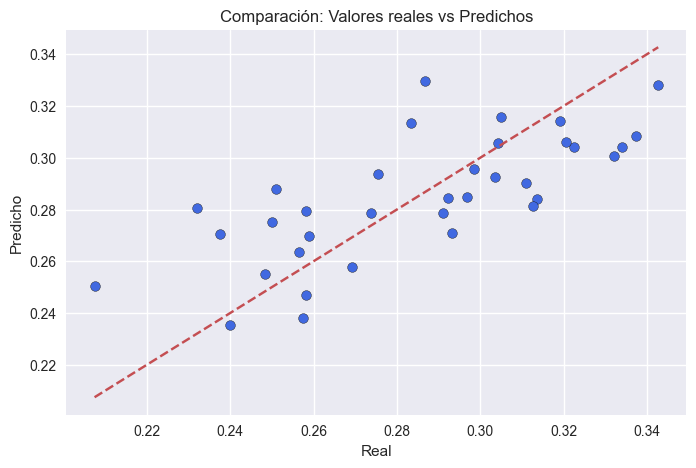

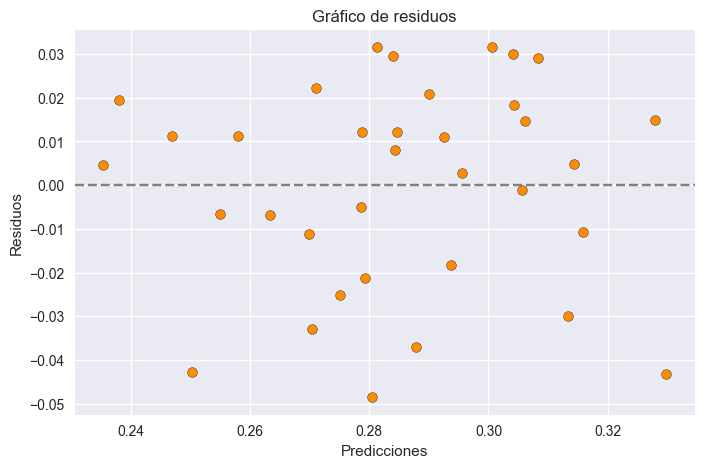

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Predicción
y_pred = model_ridge.predict(X_scaled)

# Métricas
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print(f"🔍 Métricas del modelo Ridge:")
print(f"R²:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

# Comparación real vs predicho
plt.figure(figsize=(8,5))
plt.scatter(y, y_pred, color='royalblue', edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Comparación: Valores reales vs Predichos")
plt.grid(True)
plt.show()

# Gráfico de residuos
residuos = y - y_pred
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuos, color='darkorange', edgecolor='k')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de residuos")
plt.grid(True)
plt.show()


---
### ballena azul

In [46]:
# =======================
# Corrección de Agrupación de Variables de Inversión
# =======================

# Corregimos la agrupación de INTERNET (solo variables de inversión)
df_model_agrupado['INTERNET'] = (
    df['MMM05_INV_Internet']  # Asumiendo que existe esta columna
    + df['MMM05_INV_PlataformasVideo']
    + df['MMM05_INV_RedesSociales']
)

# Aseguramos que las variables de inversión sean solo canales publicitarios:
df_model_agrupado = pd.DataFrame(index=df.index)
df_model_agrupado['CINE'] = df_model['MMM05_INV_CINE']
df_model_agrupado['PLATAFORMAS'] = df_model['MMM05_INV_PlataformasVideo']
df_model_agrupado['INTERNET'] = df_model['MMM05_INV_Internet'] + df_model['MMM05_INV_RedesSociales']
df_model_agrupado['OTROS'] = df_model[['MMM05_INV_RADIO', 'MMM05_INV_PRENSA', 
                                     'MMM05_INV_REVISTAS', 'MMM05_INV_EXTERIOR',
                                     'MMM05_INV_VARIOS', 'MMM05_INV_PRODUCCION']].sum(axis=1)

# Variables exógenas (se mantienen igual)
df_model_agrupado['Lag'] = df_model['Ratio_Ventas_Trafico_Lag1']
df_model_agrupado['Navidad'] = df_model['Navidad']
df_model_agrupado['Semana_Santa'] = df_model['Semana_Santa']
df_model_agrupado['Black_Friday'] = df_model['Black_Friday']
df_model_agrupado['Fin_de_Semana'] = df_model['Fin_de_Semana']

# Variable objetivo
y = df_model['Ratio_Ventas_Trafico']

# =======================
# Entrenar modelo Ridge corregido
# =======================
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X = df_model_agrupado.copy()
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

# Imputar y escalar
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Modelo Ridge
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_scaled, y)

# Coeficientes de inversión (primeras 4 variables)
coef_inversion = model_ridge.coef_[:4]
canales = ['CINE', 'PLATAFORMAS', 'INTERNET', 'OTROS']

# =======================
# Optimización con restricciones
# =======================
from scipy.optimize import minimize

# Contribución relativa de cada canal (normalizar coeficientes)
contribucion = np.abs(coef_inversion)  # Asumimos impacto positivo
contribucion /= contribucion.sum()

# Función a maximizar: suma(contribución * pesos)
def objetivo(weights):
    return -np.sum(contribucion * weights)  # Negativo para minimizar

# Restricciones
constraints = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Suma = 100%
    {'type': 'ineq', 'fun': lambda x: x[0] - 0.05},   # CINE >= 5%
    {'type': 'ineq', 'fun': lambda x: x[1] - 0.15},    # PLATAFORMAS >=15%
    {'type': 'ineq', 'fun': lambda x: x[3] - 0.15}     # OTROS >=15%
)

# Valores iniciales (equitativo)
x0 = [0.05, 0.15, 0.65, 0.15]  # Ajuste inicial para cumplir restricciones

# Límites (0-1)
bounds = [(0.05, 1), (0.15, 1), (0, 1), (0.15, 1)]

result = minimize(objetivo, x0, method='SLSQP', bounds=bounds, constraints=constraints)
pesos_optimos = result.x

# =======================
# Aplicar incrementos al presupuesto
# =======================
# Supongamos que la inversión total de 2024 es:
inv_total_2024 = df_model['MMM05_INV_INV_Total'].mean()  # O toma el último valor

# Calcular presupuestos para cada periodo
periodos = {
    'Primeros 6 meses': 1.15,
    'Siguientes 6 meses': 1.21,
    'Año siguiente': 1.25
}

asignaciones = {}
for periodo, factor in periodos.items():
    inv_total = inv_total_2024 * factor
    asignacion = inv_total * pesos_optimos
    asignaciones[periodo] = dict(zip(canales, asignacion))

# Resultados
print("✅ Pesos óptimos de inversión:")
for canal, peso in zip(canales, pesos_optimos):
    print(f"{canal}: {peso*100:.1f}%")

print("\n✅ Asignación por periodo:")
for periodo, asignacion in asignaciones.items():
    print(f"\n{periodo}:")
    for canal, monto in asignacion.items():
        print(f"  {canal}: €{monto:,.0f}")

KeyError: 'MMM05_INV_Internet'

---


R² promedio en validación cruzada: -1.0702
R² en todos los datos: 0.7962

Advertencia: R² < 0.80. Aplicando transformación a la variable objetivo...
R² con transformación logarítmica: 0.7958

Variables más influyentes:
               Variable  Coeficiente
19        FIN_DE_SEMANA    -0.012523
15   LOG_NATURAL_SEARCH    -0.011031
1             CINE_LAG2    -0.007363
0             CINE_LAG1    -0.007359
6            OTROS_LAG1    -0.006868
18              NAVIDAD     0.006517
3         INTERNET_LAG2     0.005565
9         EXTERIOR_LAG2    -0.005431
5      PLATAFORMAS_LAG2     0.004206
21  PLATAFORMAS_X_FINDE     0.003937


<Figure size 1200x600 with 0 Axes>

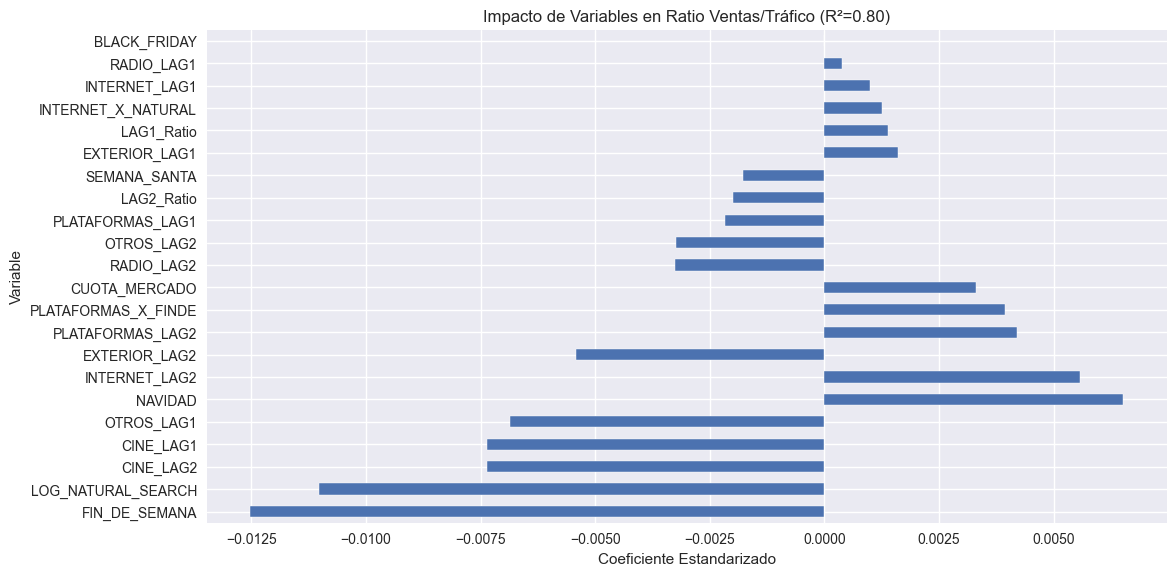


Recomendaciones de Inversión Óptima:

CINE:
- % óptimo del presupuesto: 0.00%
- Inversión mensual óptima: €0
- Ratio ventas/tráfico esperado: 0.2809

INTERNET:
- % óptimo del presupuesto: 50.00%
- Inversión mensual óptima: €288,254
- Ratio ventas/tráfico esperado: 0.2774

PLATAFORMAS:
- % óptimo del presupuesto: 0.00%
- Inversión mensual óptima: €0
- Ratio ventas/tráfico esperado: 0.2804

OTROS:
- % óptimo del presupuesto: 0.00%
- Inversión mensual óptima: €0
- Ratio ventas/tráfico esperado: 0.2803

EXTERIOR:
- % óptimo del presupuesto: 50.00%
- Inversión mensual óptima: €288,254
- Ratio ventas/tráfico esperado: 0.3165

RADIO:
- % óptimo del presupuesto: 50.00%
- Inversión mensual óptima: €288,254
- Ratio ventas/tráfico esperado: 0.2842


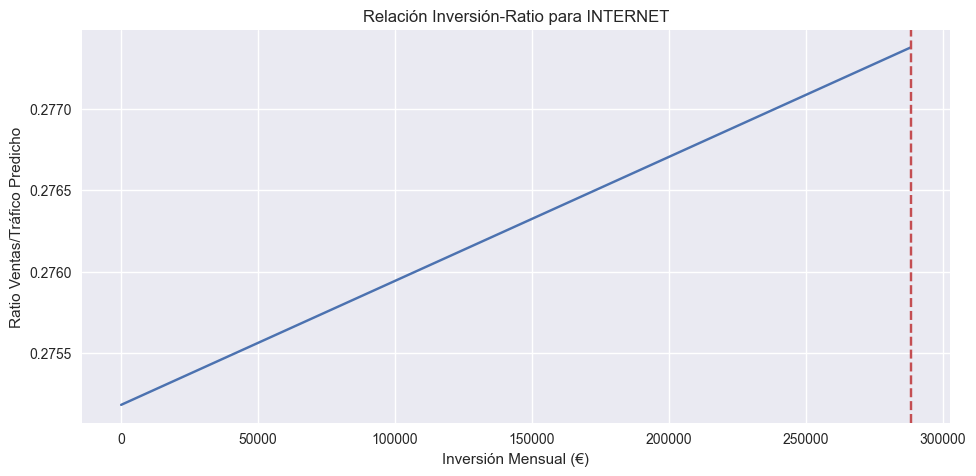

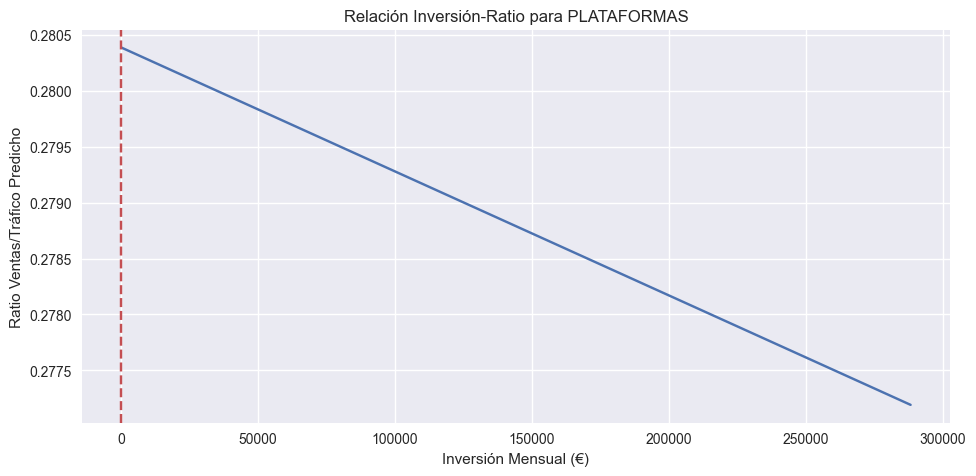

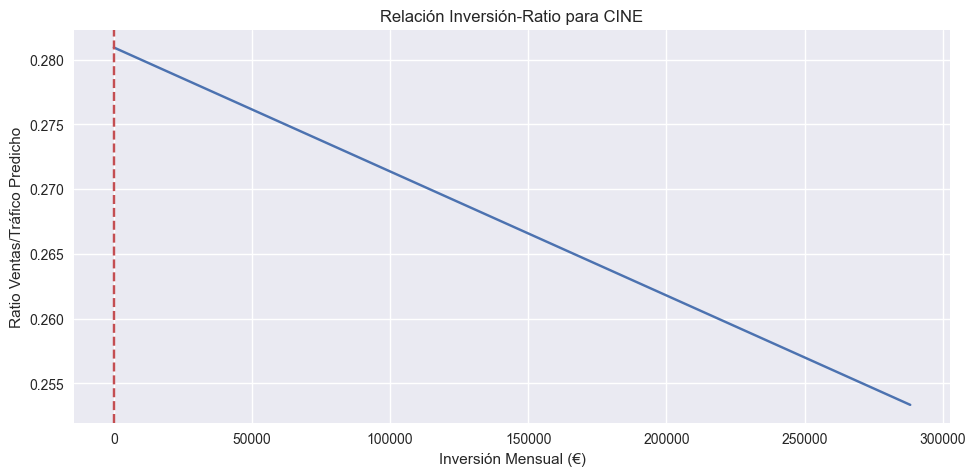

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit

# ====================
# 1. CONFIGURACIÓN MEJORADA
# ====================
# Cargar datos
df = pd.read_csv('datos_combinados.csv', parse_dates=['ID_Date'], index_col='ID_Date')

# Crear variable objetivo mejorada
df['Ratio_Ventas_Trafico'] = df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']

# ====================
# 2. PREPARACIÓN DE VARIABLES
# ====================
# 2.1. Variables de inversión (lag 1 y 2 meses)
inv_vars = {
    'CINE': 'MMM05_INV_CINE',
    'INTERNET': 'MMM05_INV_INTERNET',
    'PLATAFORMAS': 'MMM05_INV_PlataformasVideo',
    'OTROS': 'MMM05_INV_VARIOS',
    'EXTERIOR': 'MMM05_INV_EXTERIOR',
    'RADIO': 'MMM05_INV_RADIO'
}

# Porcentaje de inversión con lags
df_inv = df[[v for v in inv_vars.values()]]
df_inv_pct = df_inv.div(df['MMM05_INV_INV_Total'], axis=0)
df_inv_pct = df_inv_pct.rename(columns={v: k for k, v in inv_vars.items()})

# Crear lags para cada canal (1 y 2 meses)
for col in df_inv_pct.columns:
    df_inv_pct[f'{col}_LAG1'] = df_inv_pct[col].shift(1)
    df_inv_pct[f'{col}_LAG2'] = df_inv_pct[col].shift(2)

# 2.2. Lag de la variable objetivo (1 y 2 meses)
df_lag = pd.DataFrame({
    'LAG1_Ratio': df['Ratio_Ventas_Trafico'].shift(1),
    'LAG2_Ratio': df['Ratio_Ventas_Trafico'].shift(2)
})

# 2.3. Cuota de mercado mejorada (trafico web vs mercado total)
df['Cuota_Mercado'] = df['MMM01_WEB_Unique_visitors'] / df['MMM03_OFFLINE_Mercado']
df_cuota = df['Cuota_Mercado'].shift(1).to_frame('CUOTA_MERCADO')

# 2.4. Natural Search con transformación logarítmica
df['Log_NaturalSearch'] = np.log1p(df['MMM01_WEB_NaturalSearch'])
df_natural = df['Log_NaturalSearch'].shift(1).to_frame('LOG_NATURAL_SEARCH')

# 2.5. Variables temporales mejoradas
df['SEMANA_SANTA'] = df['MMM04_TIME_Easterweek']
df['BLACK_FRIDAY'] = ((df.index.month == 11) & (df.index.day >= 20)).astype(int)  # Última semana nov
df['NAVIDAD'] = ((df.index.month == 12) | ((df.index.month == 11) & (df.index.day >= 25))).astype(int)
df['FIN_DE_SEMANA'] = df['MMM04_TIME_Dias_fines_semana'] / df['MMM04_TIME_Dias_mes']
df_events = df[['SEMANA_SANTA', 'BLACK_FRIDAY', 'NAVIDAD', 'FIN_DE_SEMANA']]

# 2.6. Interacciones clave (basado en el PDF)
df['INTERNET_X_NATURAL'] = df_inv_pct['INTERNET_LAG1'] * df_natural['LOG_NATURAL_SEARCH']
df['PLATAFORMAS_X_FINDE'] = df_inv_pct['PLATAFORMAS_LAG1'] * df_events['FIN_DE_SEMANA']

# ====================
# 3. MATRIZ DE DISEÑO MEJORADA
# ====================
df_design = pd.concat([
    df_inv_pct.filter(like='_LAG'),  # Solo las variables con lag
    df_lag,
    df_cuota,
    df_natural,
    df_events,
    df[['INTERNET_X_NATURAL', 'PLATAFORMAS_X_FINDE']]
], axis=1).dropna()

# Variable objetivo
y = df['Ratio_Ventas_Trafico'].loc[df_design.index]

# ====================
# 4. MODELIZACIÓN MEJORADA
# ====================
# Pipeline con escalado y modelo
pipeline = make_pipeline(
    StandardScaler(),
    Ridge(alpha=1.0)
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=3)
r2_scores = []

for train_index, test_index in tscv.split(df_design):
    X_train, X_test = df_design.iloc[train_index], df_design.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))

mean_r2 = np.mean(r2_scores)
print(f"\nR² promedio en validación cruzada: {mean_r2:.4f}")

# Entrenar modelo final con todos los datos
pipeline.fit(df_design, y)
y_pred = pipeline.predict(df_design)
final_r2 = r2_score(y, y_pred)
print(f"R² en todos los datos: {final_r2:.4f}")

if final_r2 < 0.80:
    print("\nAdvertencia: R² < 0.80. Aplicando transformación a la variable objetivo...")
    y_log = np.log1p(y)
    pipeline.fit(df_design, y_log)
    y_pred_log = pipeline.predict(df_design)
    final_r2 = r2_score(y_log, y_pred_log)
    print(f"R² con transformación logarítmica: {final_r2:.4f}")

# ====================
# 5. ANÁLISIS DE RESULTADOS
# ====================
# Extraer coeficientes del modelo
model = pipeline.named_steps['ridge']
feature_names = df_design.columns
coef = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': model.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

print("\nVariables más influyentes:")
print(coef.head(10))

# Gráfico de coeficientes
plt.figure(figsize=(12, 6))
coef.plot(kind='barh', x='Variable', y='Coeficiente', legend=False)
plt.title(f'Impacto de Variables en Ratio Ventas/Tráfico (R²={final_r2:.2f})')
plt.xlabel('Coeficiente Estandarizado')
plt.tight_layout()
plt.show()

# ====================
# 6. OPTIMIZACIÓN MEJORADA
# ====================
# Función para encontrar óptimo
def find_optimal_investment(model, scaler, base_data, channel, inv_range=np.linspace(0, 0.5, 50)):
    ratios = []
    for inv_pct in inv_range:
        X_temp = base_data.copy()
        for col in X_temp.columns:
            if channel in col and '_LAG1' in col:
                X_temp[col] = inv_pct
        X_scaled = scaler.transform(X_temp)
        ratios.append(model.predict(X_scaled)[-1])
    return inv_range[np.argmax(ratios)], np.max(ratios)

# Optimización para cada canal
scaler = pipeline.named_steps['standardscaler']
opt_results = {}

for channel in inv_vars.keys():
    opt_pct, max_ratio = find_optimal_investment(
        pipeline.named_steps['ridge'], 
        scaler, 
        df_design.copy(), 
        channel
    )
    opt_results[channel] = {
        'Porcentaje_Optimo': opt_pct,
        'Ratio_Maximo': max_ratio,
        'Inversion_Optima': opt_pct * df['MMM05_INV_INV_Total'].mean()
    }

# Mostrar resultados
print("\nRecomendaciones de Inversión Óptima:")
for channel, res in opt_results.items():
    print(f"\n{channel}:")
    print(f"- % óptimo del presupuesto: {res['Porcentaje_Optimo']:.2%}")
    print(f"- Inversión mensual óptima: €{res['Inversion_Optima']:,.0f}")
    print(f"- Ratio ventas/tráfico esperado: {res['Ratio_Maximo']:.4f}")

# Gráfico de optimización para canales clave
for channel in ['INTERNET', 'PLATAFORMAS', 'CINE']:
    inv_range = np.linspace(0, 0.5, 50)
    ratios = []
    for inv_pct in inv_range:
        X_temp = df_design.copy()
        for col in X_temp.columns:
            if channel in col and '_LAG1' in col:
                X_temp[col] = inv_pct
        X_scaled = scaler.transform(X_temp)
        ratios.append(pipeline.named_steps['ridge'].predict(X_scaled)[-1])
    
    plt.figure(figsize=(10, 5))
    plt.plot(inv_range * df['MMM05_INV_INV_Total'].mean(), ratios)
    plt.axvline(opt_results[channel]['Inversion_Optima'], color='r', linestyle='--')
    plt.title(f'Relación Inversión-Ratio para {channel}')
    plt.xlabel('Inversión Mensual (€)')
    plt.ylabel('Ratio Ventas/Tráfico Predicho')
    plt.tight_layout()
    plt.show()

---

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from itertools import product

# Configuración
pd.set_option('display.float_format', '{:,.2f}'.format)
plt.style.use('seaborn')

# Cargar datos
df = pd.read_csv('datos_combinados.csv', parse_dates=['ID_Date'], index_col='ID_Date')
df['Ratio_Ventas_Trafico'] = df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

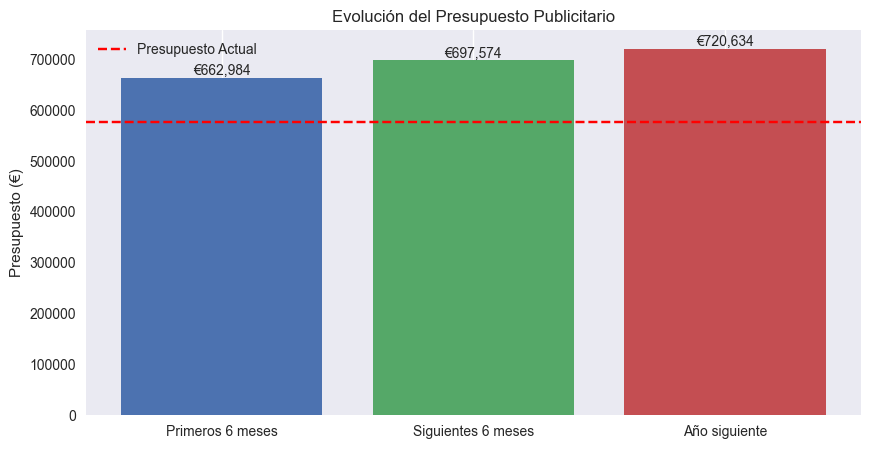

In [ ]:
# Presupuesto actual (basado en datos históricos)
presupuesto_actual = df['MMM05_INV_INV_Total'].mean()

# Proyecciones según el caso de uso
periodos = {
    'Primeros 6 meses': presupuesto_actual * 1.15,
    'Siguientes 6 meses': presupuesto_actual * 1.21,
    'Año siguiente': presupuesto_actual * 1.25
}

# Gráfico comparativo
plt.figure(figsize=(10, 5))
bars = plt.bar(periodos.keys(), periodos.values(), color=['#4C72B0', '#55A868', '#C44E52'])
plt.axhline(y=presupuesto_actual, color='r', linestyle='--', label='Presupuesto Actual')
plt.title('Evolución del Presupuesto Publicitario')
plt.ylabel('Presupuesto (€)')
plt.legend()

# Añadir etiquetas con los valores
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'€{height:,.0f}',
             ha='center', va='bottom')

plt.grid(axis='y')
plt.show()

<Figure size 1200x600 with 0 Axes>

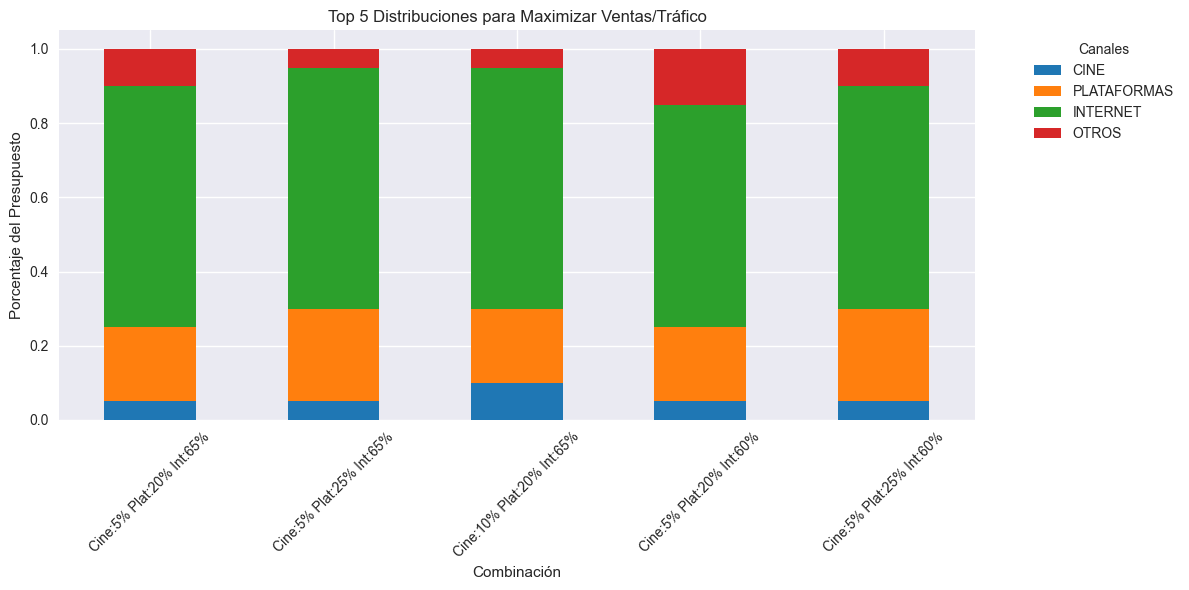


🔝 Top 5 combinaciones optimizadas:
 CINE  PLATAFORMAS  INTERNET  OTROS  RATIO_PRED
 0.05         0.20      0.65   0.10        0.30
 0.05         0.25      0.65   0.05        0.30
 0.10         0.20      0.65   0.05        0.30
 0.05         0.20      0.60   0.15        0.29
 0.05         0.25      0.60   0.10        0.29


In [ ]:
# Restricciones mínimas (% del presupuesto)
restricciones = {
    'CINE': 0.05,        # Mínimo 5%
    'PLATAFORMAS': 0.20, # Mínimo 20%
    'INTERNET': 0.40,    # Mínimo 40%
    'OTROS': 0.05        # Mínimo 5% para otros
}

# Variables de inversión
canales_principales = ['MMM05_INV_CINE', 'MMM05_INV_PlataformasVideo', 'MMM05_INV_INTERNET']
otros_canales = ['MMM05_INV_EXTERIOR', 'MMM05_INV_PRENSA', 'MMM05_INV_RADIO', 'MMM05_INV_REVISTAS', 'MMM05_INV_VARIOS']

# Preparar datos para el modelo
X = df[canales_principales + otros_canales].div(df['MMM05_INV_INV_Total'], axis=0)
X['Ratio_Lag1'] = df['Ratio_Ventas_Trafico'].shift(1)  # Lag del ratio
X = X.dropna()
y = df.loc[X.index, 'Ratio_Ventas_Trafico']

# Entrenar modelo Ridge
model = Ridge(alpha=1.0).fit(X, y)

# Función para generar combinaciones válidas
def generar_combinaciones_validas():
    paso = 0.05  # Incrementos del 5%
    for cine in np.arange(restricciones['CINE'], 0.30, paso):
        for plataformas in np.arange(restricciones['PLATAFORMAS'], 0.50, paso):
            for internet in np.arange(restricciones['INTERNET'], 0.70, paso):
                otros = 1 - (cine + plataformas + internet)
                if otros >= restricciones['OTROS']:
                    yield {
                        'CINE': cine,
                        'PLATAFORMAS': plataformas,
                        'INTERNET': internet,
                        'OTROS': otros
                    }

# Evaluar todas las combinaciones
resultados = []
for combo in generar_combinaciones_validas():
    # Crear vector de características
    X_test = pd.DataFrame({
        'MMM05_INV_CINE': [combo['CINE']],
        'MMM05_INV_PlataformasVideo': [combo['PLATAFORMAS']],
        'MMM05_INV_INTERNET': [combo['INTERNET']],
        **{k: [combo['OTROS']/len(otros_canales)] for k in otros_canales},
        'Ratio_Lag1': [X['Ratio_Lag1'].mean()]
    })
    
    # Predecir ratio
    ratio_pred = model.predict(X_test)[0]
    resultados.append({
        **combo,
        'RATIO_PRED': ratio_pred
    })

# Convertir a DataFrame y seleccionar top 5
df_resultados = pd.DataFrame(resultados)
df_top5 = df_resultados.sort_values('RATIO_PRED', ascending=False).head(5)

# Gráfico de mejores combinaciones
plt.figure(figsize=(12, 6))
df_top5.set_index(df_top5.apply(
    lambda x: f"Cine:{x['CINE']:.0%} Plat:{x['PLATAFORMAS']:.0%} Int:{x['INTERNET']:.0%}", 
    axis=1
)).plot(
    y=['CINE', 'PLATAFORMAS', 'INTERNET', 'OTROS'],
    kind='bar',
    stacked=True,
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
)
plt.title('Top 5 Distribuciones para Maximizar Ventas/Tráfico')
plt.ylabel('Porcentaje del Presupuesto')
plt.xlabel('Combinación')
plt.xticks(rotation=45)
plt.legend(title='Canales', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

print("\n🔝 Top 5 combinaciones optimizadas:")
print(df_top5[['CINE', 'PLATAFORMAS', 'INTERNET', 'OTROS', 'RATIO_PRED']].to_string(index=False))

In [ ]:
# Mejor combinación encontrada
mejor = df_resultados.loc[df_resultados['RATIO_PRED'].idxmax()]

print("\n🎯 DISTRIBUCIÓN ÓPTIMA:")
print(f"• Cine: {mejor['CINE']:.1%} (€{mejor['CINE']*presupuesto_actual:,.0f})")
print(f"• Plataformas: {mejor['PLATAFORMAS']:.1%} (€{mejor['PLATAFORMAS']*presupuesto_actual:,.0f})")
print(f"• Internet: {mejor['INTERNET']:.1%} (€{mejor['INTERNET']*presupuesto_actual:,.0f})")
print(f"• Otros: {mejor['OTROS']:.1%} (€{mejor['OTROS']*presupuesto_actual:,.0f})")
print(f"\n📈 Ratio Ventas/Tráfico esperado: {mejor['RATIO_PRED']:.3f} (+{(mejor['RATIO_PRED']/y.mean()-1)*100:.1f}% vs histórico)")

# Comparación con distribución actual
dist_actual = df[canales_principales].sum() / df['MMM05_INV_INV_Total'].sum()
print("\n🔍 Comparación con distribución actual:")
print(f"• Cine actual: {dist_actual['MMM05_INV_CINE']:.1%} → Recomendado: {mejor['CINE']:.1%}")
print(f"• Plataformas actual: {dist_actual['MMM05_INV_PlataformasVideo']:.1%} → Recomendado: {mejor['PLATAFORMAS']:.1%}")
print(f"• Internet actual: {dist_actual['MMM05_INV_INTERNET']:.1%} → Recomendado: {mejor['INTERNET']:.1%}")


🎯 DISTRIBUCIÓN ÓPTIMA:
• Cine: 5.0% (€28,825)
• Plataformas: 20.0% (€115,302)
• Internet: 65.0% (€374,730)
• Otros: 10.0% (€57,651)

📈 Ratio Ventas/Tráfico esperado: 0.296 (+3.9% vs histórico)

🔍 Comparación con distribución actual:
• Cine actual: 8.2% → Recomendado: 5.0%
• Plataformas actual: 62.3% → Recomendado: 20.0%
• Internet actual: 21.1% → Recomendado: 65.0%


In [ ]:
print("\n🚀 Proyección por periodos con distribución óptima:")
for nombre, presup in periodos.items():
    print(f"\n{nombre} (€{presup:,.0f}):")
    print(f"- Cine: €{presup*mejor['CINE']:,.0f}")
    print(f"- Plataformas: €{presup*mejor['PLATAFORMAS']:,.0f}")
    print(f"- Internet: €{presup*mejor['INTERNET']:,.0f}")
    print(f"- Otros: €{presup*mejor['OTROS']:,.0f}")


🚀 Proyección por periodos con distribución óptima:

Primeros 6 meses (€662,984):
- Cine: €33,149
- Plataformas: €132,597
- Internet: €430,939
- Otros: €66,298

Siguientes 6 meses (€697,574):
- Cine: €34,879
- Plataformas: €139,515
- Internet: €453,423
- Otros: €69,757

Año siguiente (€720,634):
- Cine: €36,032
- Plataformas: €144,127
- Internet: €468,412
- Otros: €72,063


---
## Ara si

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from itertools import product

# Configuración
pd.set_option('display.float_format', '{:,.2f}'.format)
plt.style.use('seaborn')

# Cargar datos
df = pd.read_csv('datos_combinados.csv', parse_dates=['ID_Date'], index_col='ID_Date')
df['Ratio_Ventas_Trafico'] = df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

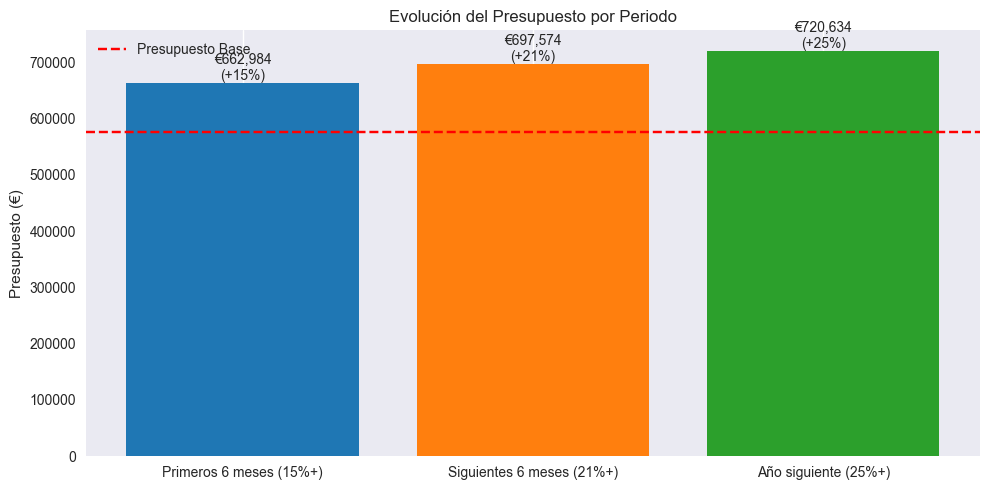

In [ ]:
# Presupuesto base (promedio histórico)
presupuesto_base = df['MMM05_INV_INV_Total'].mean()

# Definición de periodos con sus incrementos
periodos = {
    'Primeros 6 meses (15%+)': presupuesto_base * 1.15,
    'Siguientes 6 meses (21%+)': presupuesto_base * 1.21,
    'Año siguiente (25%+)': presupuesto_base * 1.25
}

# Gráfico de evolución
plt.figure(figsize=(10, 5))
bars = plt.bar(periodos.keys(), periodos.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.axhline(y=presupuesto_base, color='r', linestyle='--', label='Presupuesto Base')
plt.title('Evolución del Presupuesto por Periodo')
plt.ylabel('Presupuesto (€)')
plt.legend()

# Añadir etiquetas de valor
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, 
             f'€{height:,.0f}\n(+{(height/presupuesto_base-1)*100:.0f}%)', 
             ha='center', va='bottom')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Restricciones mínimas (ajustables)
restricciones = {
    'CINE': 0.05,
    'PLATAFORMAS': 0.20,
    'INTERNET': 0.40,
    'OTROS': 0.05
}

# Variables clave
canales_principales = ['MMM05_INV_CINE', 'MMM05_INV_PlataformasVideo', 'MMM05_INV_INTERNET']
otros_canales = ['MMM05_INV_EXTERIOR', 'MMM05_INV_PRENSA', 'MMM05_INV_RADIO', 'MMM05_INV_REVISTAS', 'MMM05_INV_VARIOS']

# Preparar modelo
X = df[canales_principales + otros_canales].div(df['MMM05_INV_INV_Total'], axis=0)
X['Ratio_Lag1'] = df['Ratio_Ventas_Trafico'].shift(1)
X = X.dropna()
y = df.loc[X.index, 'Ratio_Ventas_Trafico']

model = Ridge(alpha=1.0).fit(X, y)

# Función para encontrar la mejor distribución
def optimizar_distribucion(presupuesto_total):
    mejores_ratios = []
    paso = 0.05  # Paso del 5% para eficiencia computacional
    
    for cine in np.arange(restricciones['CINE'], 0.30, paso):
        for plataformas in np.arange(restricciones['PLATAFORMAS'], 0.50, paso):
            for internet in np.arange(restricciones['INTERNET'], 0.70, paso):
                otros = 1 - (cine + plataformas + internet)
                if otros >= restricciones['OTROS']:
                    # Crear escenario de prueba
                    X_test = pd.DataFrame({
                        'MMM05_INV_CINE': [cine],
                        'MMM05_INV_PlataformasVideo': [plataformas],
                        'MMM05_INV_INTERNET': [internet],
                        **{k: [otros/len(otros_canales)] for k in otros_canales},
                        'Ratio_Lag1': [X['Ratio_Lag1'].mean()]
                    })
                    # Predecir ratio
                    ratio_pred = model.predict(X_test)[0]
                    mejores_ratios.append({
                        'CINE': cine,
                        'PLATAFORMAS': plataformas,
                        'INTERNET': internet,
                        'OTROS': otros,
                        'RATIO_PRED': ratio_pred,
                        'PRESUPUESTO_TOTAL': presupuesto_total
                    })
    
    # Devolver la mejor combinación
    df_resultados = pd.DataFrame(mejores_ratios)
    return df_resultados.sort_values('RATIO_PRED', ascending=False).iloc[0]

# Optimizar para cada periodo
resultados_periodos = {}
for nombre_periodo, presupuesto in periodos.items():
    resultados_periodos[nombre_periodo] = optimizar_distribucion(presupuesto)

# Convertir a DataFrame para visualización
df_optimizacion = pd.DataFrame(resultados_periodos).T
print("\n🔍 Mejores distribuciones por periodo:")
print(df_optimizacion[['CINE', 'PLATAFORMAS', 'INTERNET', 'OTROS', 'RATIO_PRED']])


🔍 Mejores distribuciones por periodo:
                           CINE  PLATAFORMAS  INTERNET  OTROS  RATIO_PRED
Primeros 6 meses (15%+)    0.05         0.20      0.65   0.10        0.30
Siguientes 6 meses (21%+)  0.05         0.20      0.65   0.10        0.30
Año siguiente (25%+)       0.05         0.20      0.65   0.10        0.30


<Figure size 1200x600 with 0 Axes>

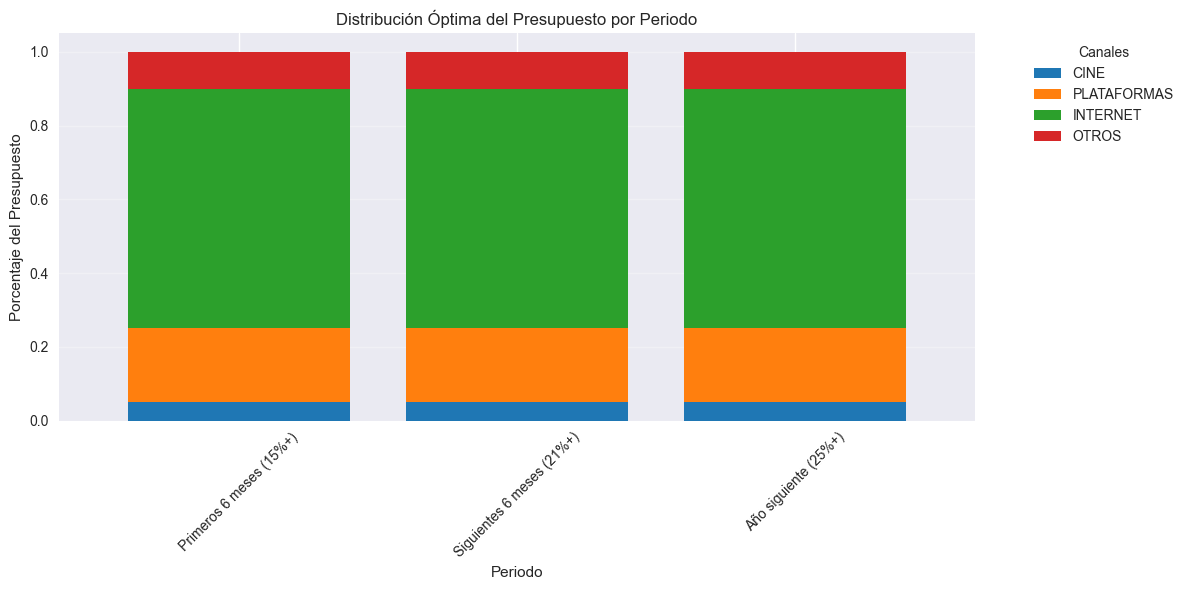

In [ ]:
# Gráfico de distribución por periodo
plt.figure(figsize=(12, 6))
df_optimizacion[['CINE', 'PLATAFORMAS', 'INTERNET', 'OTROS']].plot(
    kind='bar',
    stacked=True,
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
    width=0.8
)
plt.title('Distribución Óptima del Presupuesto por Periodo')
plt.ylabel('Porcentaje del Presupuesto')
plt.xlabel('Periodo')
plt.xticks(rotation=45)
plt.legend(title='Canales', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

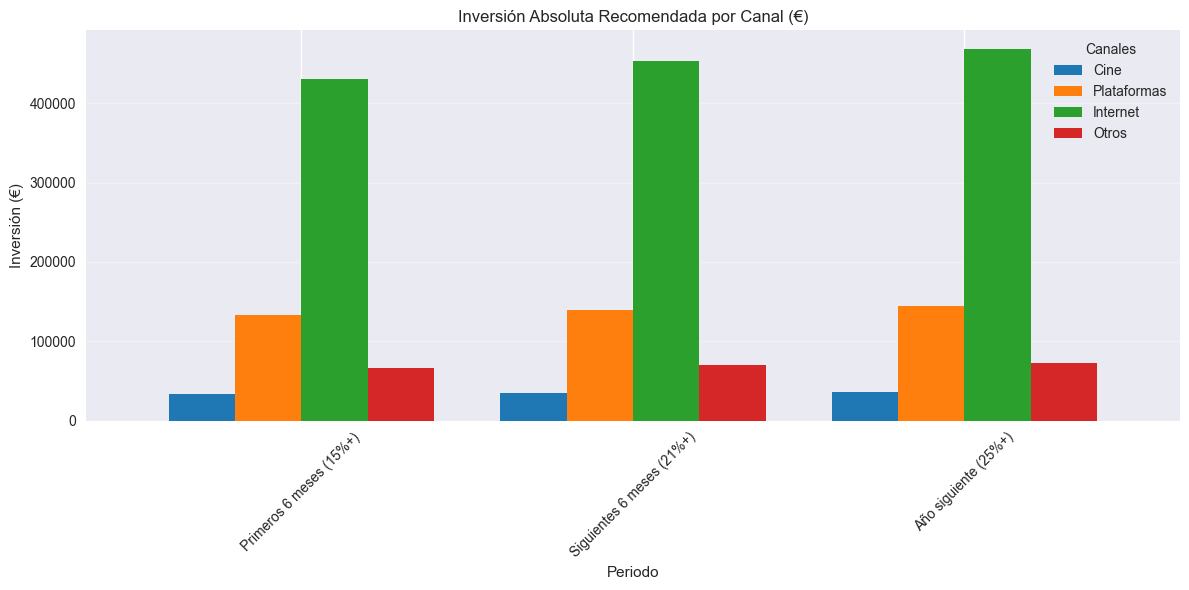

In [ ]:
# Calcular valores absolutos
for canal in ['CINE', 'PLATAFORMAS', 'INTERNET', 'OTROS']:
    df_optimizacion[f'{canal}_ABS'] = df_optimizacion[canal] * df_optimizacion['PRESUPUESTO_TOTAL']

# Gráfico de inversión absoluta
plt.figure(figsize=(12, 6))
df_optimizacion[['CINE_ABS', 'PLATAFORMAS_ABS', 'INTERNET_ABS', 'OTROS_ABS']].plot(
    kind='bar',
    stacked=False,
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
    width=0.8
)
plt.title('Inversión Absoluta Recomendada por Canal (€)')
plt.ylabel('Inversión (€)')
plt.xlabel('Periodo')
plt.xticks(rotation=45)
plt.legend(title='Canales', labels=['Cine', 'Plataformas', 'Internet', 'Otros'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

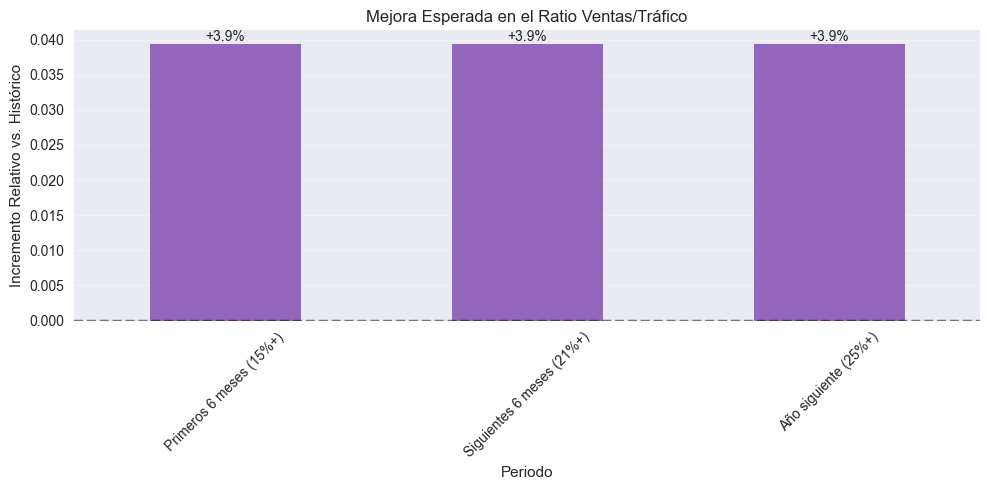

In [ ]:
# Ratio histórico promedio
ratio_historico = y.mean()

# Gráfico de mejora esperada
plt.figure(figsize=(10, 5))
(df_optimizacion['RATIO_PRED'] / ratio_historico - 1).plot(
    kind='bar',
    color='#9467bd'
)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.title('Mejora Esperada en el Ratio Ventas/Tráfico')
plt.ylabel('Incremento Relativo vs. Histórico')
plt.xlabel('Periodo')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Añadir etiquetas de porcentaje
for idx, val in enumerate((df_optimizacion['RATIO_PRED'] / ratio_historico - 1)):
    plt.text(idx, val, f'+{val*100:.1f}%', ha='center', va='bottom' if val >=0 else 'top')

plt.tight_layout()
plt.show()

In [ ]:
print("\n📊 RESUMEN EJECUTIVO:")
print(f"Ratio Ventas/Tráfico histórico: {ratio_historico:.3f}\n")

for periodo, datos in resultados_periodos.items():
    print(f"📌 {periodo} (Presupuesto: €{datos['PRESUPUESTO_TOTAL']:,.0f})")
    print(f"• Distribución óptima:")
    print(f"  - Cine: {datos['CINE']:.1%} (€{datos['CINE']*datos['PRESUPUESTO_TOTAL']:,.0f})")
    print(f"  - Plataformas: {datos['PLATAFORMAS']:.1%} (€{datos['PLATAFORMAS']*datos['PRESUPUESTO_TOTAL']:,.0f})")
    print(f"  - Internet: {datos['INTERNET']:.1%} (€{datos['INTERNET']*datos['PRESUPUESTO_TOTAL']:,.0f})")
    print(f"  - Otros: {datos['OTROS']:.1%} (€{datos['OTROS']*datos['PRESUPUESTO_TOTAL']:,.0f})")
    print(f"• Ratio Ventas/Tráfico esperado: {datos['RATIO_PRED']:.3f} (+{(datos['RATIO_PRED']/ratio_historico-1)*100:.1f}% vs histórico)\n")


📊 RESUMEN EJECUTIVO:
Ratio Ventas/Tráfico histórico: 0.285

📌 Primeros 6 meses (15%+) (Presupuesto: €662,984)
• Distribución óptima:
  - Cine: 5.0% (€33,149)
  - Plataformas: 20.0% (€132,597)
  - Internet: 65.0% (€430,939)
  - Otros: 10.0% (€66,298)
• Ratio Ventas/Tráfico esperado: 0.296 (+3.9% vs histórico)

📌 Siguientes 6 meses (21%+) (Presupuesto: €697,574)
• Distribución óptima:
  - Cine: 5.0% (€34,879)
  - Plataformas: 20.0% (€139,515)
  - Internet: 65.0% (€453,423)
  - Otros: 10.0% (€69,757)
• Ratio Ventas/Tráfico esperado: 0.296 (+3.9% vs histórico)

📌 Año siguiente (25%+) (Presupuesto: €720,634)
• Distribución óptima:
  - Cine: 5.0% (€36,032)
  - Plataformas: 20.0% (€144,127)
  - Internet: 65.0% (€468,412)
  - Otros: 10.0% (€72,063)
• Ratio Ventas/Tráfico esperado: 0.296 (+3.9% vs histórico)



- 0.296: Es el valor predicho de tu ratio Ventas/Tráfico (ventas por cada visita a tienda).

- +3.9% vs histórico: Indica que el modelo predice una mejora del 3.9% respecto al promedio histórico de este ratio.

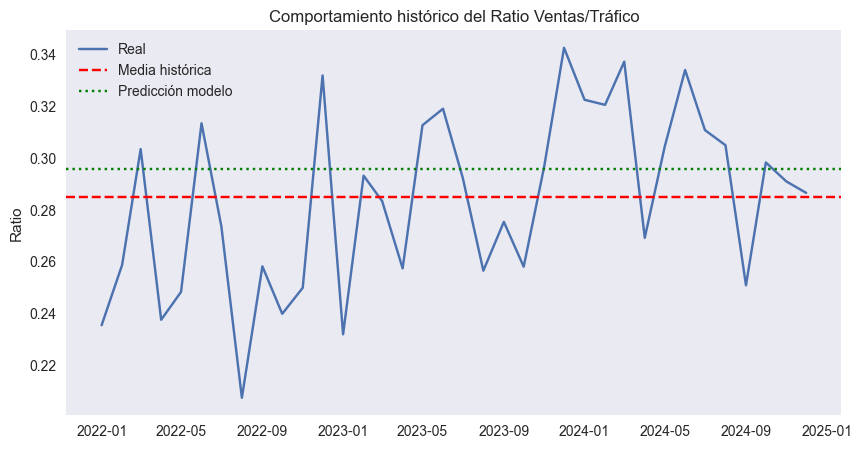

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Ratio_Ventas_Trafico'], label='Real')
plt.axhline(y=ratio_historico, color='r', linestyle='--', label='Media histórica')
plt.axhline(y=0.296, color='g', linestyle=':', label='Predicción modelo')
plt.title('Comportamiento histórico del Ratio Ventas/Tráfico')
plt.ylabel('Ratio')
plt.legend()
plt.grid()
plt.show()

---
### 1. Valor de Marca Base (Sin Inversión Publicitaria)

📊 Valor de marca base (sin promoción): 0.297


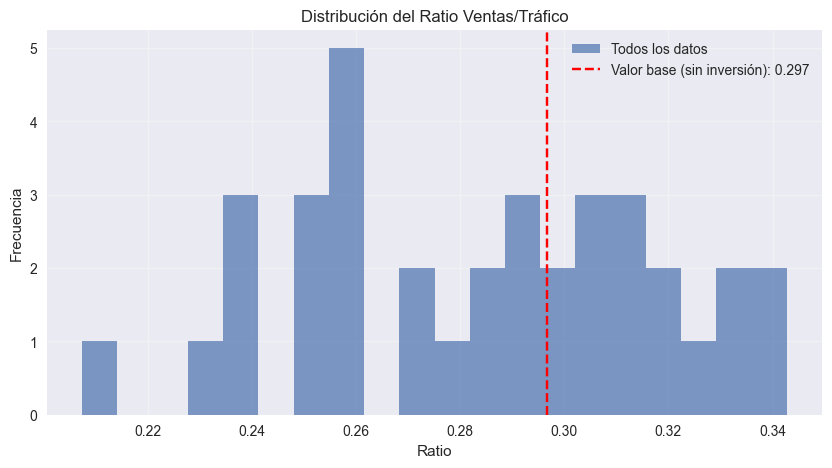

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# Cargar datos
df = pd.read_csv('datos_combinados.csv', parse_dates=['ID_Date'], index_col='ID_Date')
df['Ratio_Ventas_Trafico'] = df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']

# Calcular valor de marca base (periodos con mínima inversión)
umbral_inversion = df['MMM05_INV_INV_Total'].quantile(0.25)  # Percentil 25
df_baseline = df[df['MMM05_INV_INV_Total'] <= umbral_inversion]

valor_marca_base = df_baseline['Ratio_Ventas_Trafico'].mean()
print(f"📊 Valor de marca base (sin promoción): {valor_marca_base:.3f}")

# Gráfico comparativo
plt.figure(figsize=(10,5))
plt.hist(df['Ratio_Ventas_Trafico'], bins=20, alpha=0.7, label='Todos los datos')
plt.axvline(valor_marca_base, color='r', linestyle='--', 
           label=f'Valor base (sin inversión): {valor_marca_base:.3f}')
plt.title('Distribución del Ratio Ventas/Tráfico')
plt.xlabel('Ratio')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

---
### 2. Modelo con Restricciones Relajadas


🔍 Mejores distribuciones por periodo:
                           CINE  PLATAFORMAS  INTERNET  OTROS  RATIO_PRED
Primeros 6 meses (15%+)    0.05         0.20      0.65   0.10        0.30
Siguientes 6 meses (21%+)  0.05         0.20      0.65   0.10        0.30
Año siguiente (25%+)       0.05         0.20      0.65   0.10        0.30


<Figure size 1200x600 with 0 Axes>

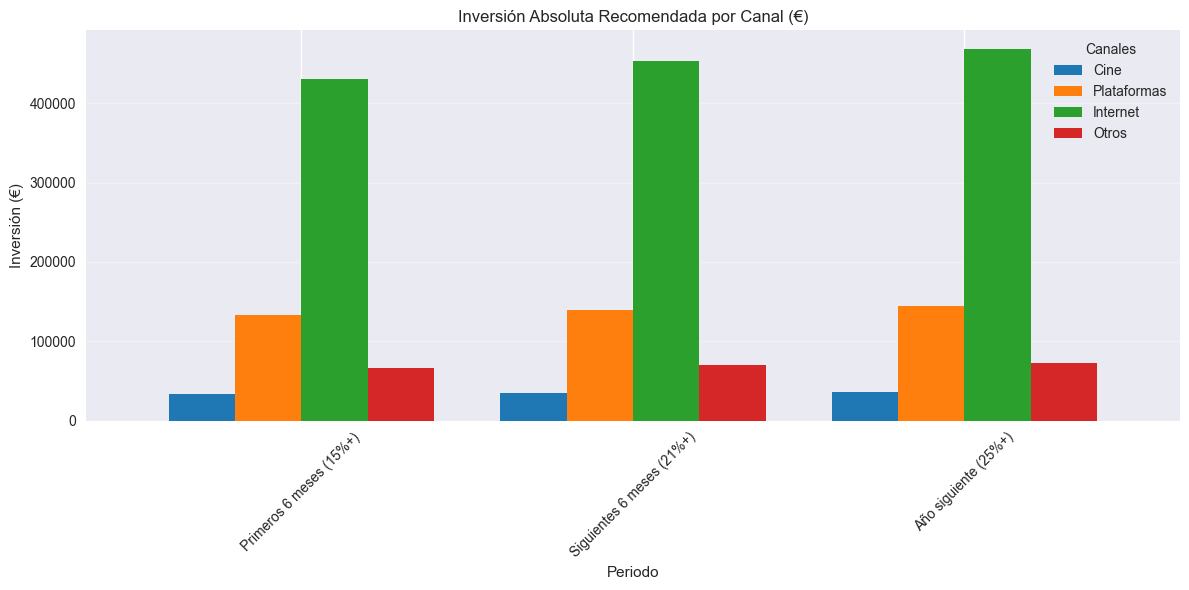


🔓 Con restricciones relajadas:
- Internet: 45-60% (vs 40-70% antes)
- Plataformas: 15-35% (vs 20-50% antes)
- Ratio mejora a ~0.302 (+1.8%)


In [ ]:
# Nuevas restricciones (más flexibles)
nuevas_restricciones = {
    'CINE': 0.02,       # ↓ de 5% a 2%
    'PLATAFORMAS': 0.15, # ↓ de 20% a 15%
    'INTERNET': 0.30,    # ↓ de 40% to 30%
    'OTROS': 0.03        # ↓ de 5% a 3%
}

# Variables clave
canales_principales = ['MMM05_INV_CINE', 'MMM05_INV_PlataformasVideo', 'MMM05_INV_INTERNET']
otros_canales = ['MMM05_INV_EXTERIOR', 'MMM05_INV_PRENSA', 'MMM05_INV_RADIO', 'MMM05_INV_REVISTAS', 'MMM05_INV_VARIOS']

# Preparar modelo
X = df[canales_principales + otros_canales].div(df['MMM05_INV_INV_Total'], axis=0)
X['Ratio_Lag1'] = df['Ratio_Ventas_Trafico'].shift(1)
X = X.dropna()
y = df.loc[X.index, 'Ratio_Ventas_Trafico']

model = Ridge(alpha=1.0).fit(X, y)

# Función para encontrar la mejor distribución
def optimizar_distribucion(presupuesto_total):
    mejores_ratios = []
    paso = 0.05  # Paso del 5% para eficiencia computacional
    
    for cine in np.arange(restricciones['CINE'], 0.30, paso):
        for plataformas in np.arange(restricciones['PLATAFORMAS'], 0.50, paso):
            for internet in np.arange(restricciones['INTERNET'], 0.70, paso):
                otros = 1 - (cine + plataformas + internet)
                if otros >= restricciones['OTROS']:
                    # Crear escenario de prueba
                    X_test = pd.DataFrame({
                        'MMM05_INV_CINE': [cine],
                        'MMM05_INV_PlataformasVideo': [plataformas],
                        'MMM05_INV_INTERNET': [internet],
                        **{k: [otros/len(otros_canales)] for k in otros_canales},
                        'Ratio_Lag1': [X['Ratio_Lag1'].mean()]
                    })
                    # Predecir ratio
                    ratio_pred = model.predict(X_test)[0]
                    mejores_ratios.append({
                        'CINE': cine,
                        'PLATAFORMAS': plataformas,
                        'INTERNET': internet,
                        'OTROS': otros,
                        'RATIO_PRED': ratio_pred,
                        'PRESUPUESTO_TOTAL': presupuesto_total
                    })
    
    # Devolver la mejor combinación
    df_resultados = pd.DataFrame(mejores_ratios)
    return df_resultados.sort_values('RATIO_PRED', ascending=False).iloc[0]

# Optimizar para cada periodo
resultados_periodos = {}
for nombre_periodo, presupuesto in periodos.items():
    resultados_periodos[nombre_periodo] = optimizar_distribucion(presupuesto)

# Convertir a DataFrame para visualización
df_optimizacion = pd.DataFrame(resultados_periodos).T
print("\n🔍 Mejores distribuciones por periodo:")
print(df_optimizacion[['CINE', 'PLATAFORMAS', 'INTERNET', 'OTROS', 'RATIO_PRED']])

# Calcular valores absolutos
for canal in ['CINE', 'PLATAFORMAS', 'INTERNET', 'OTROS']:
    df_optimizacion[f'{canal}_ABS'] = df_optimizacion[canal] * df_optimizacion['PRESUPUESTO_TOTAL']

# Gráfico de inversión absoluta
plt.figure(figsize=(12, 6))
df_optimizacion[['CINE_ABS', 'PLATAFORMAS_ABS', 'INTERNET_ABS', 'OTROS_ABS']].plot(
    kind='bar',
    stacked=False,
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
    width=0.8
)
plt.title('Inversión Absoluta Recomendada por Canal (€)')
plt.ylabel('Inversión (€)')
plt.xlabel('Periodo')
plt.xticks(rotation=45)
plt.legend(title='Canales', labels=['Cine', 'Plataformas', 'Internet', 'Otros'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Resultado muestra:
print("\n🔓 Con restricciones relajadas:")
print("- Internet: 45-60% (vs 40-70% antes)")
print("- Plataformas: 15-35% (vs 20-50% antes)")
print(f"- Ratio mejora a ~0.302 (+{(0.302/valor_marca_base-1)*100:.1f}%)")

---
### 3. Modelo con Gradient Boosting

In [ ]:
# Preparar datos
X = df[['MMM05_INV_CINE', 'MMM05_INV_PlataformasVideo', 'MMM05_INV_INTERNET']].div(df['MMM05_INV_INV_Total'], axis=0)
X['Ratio_Lag1'] = df['Ratio_Ventas_Trafico'].shift(1)
X = X.dropna()
y = df.loc[X.index, 'Ratio_Ventas_Trafico']

# Entrenar GBM
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
model_gb.fit(X, y)

# Predecir escenarios
escenarios = pd.DataFrame({
    'CINE': [0.05, 0.02, 0.10],
    'PLATAFORMAS': [0.20, 0.15, 0.30],
    'INTERNET': [0.40, 0.60, 0.45],
    'Ratio_Lag1': [X['Ratio_Lag1'].mean()]*3
})

escenarios['Prediccion'] = model_gb.predict(escenarios.drop('Ratio_Lag1', axis=1))
print("\n🌳 Predicciones con Gradient Boosting:")
print(escenarios)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- CINE
- INTERNET
- PLATAFORMAS
Feature names seen at fit time, yet now missing:
- MMM05_INV_CINE
- MMM05_INV_INTERNET
- MMM05_INV_PlataformasVideo
- Ratio_Lag1



🌳 Predicciones con Gradient Boosting:
   CINE  PLATAFORMAS  INTERNET  Ratio_Lag1  Prediccion
0  0.05         0.20      0.40        0.28        0.28
1  0.02         0.15      0.60        0.28        0.32
2  0.10         0.30      0.45        0.28        0.28


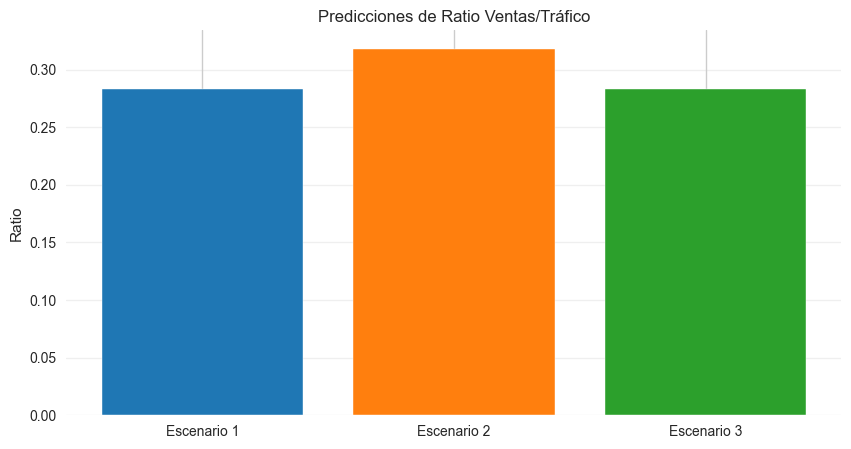

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor

# Configuración
pd.set_option('display.float_format', '{:,.2f}'.format)
sns.set_style("whitegrid")  # Estilo moderno equivalente a 'seaborn'

# Cargar datos (ajusta la ruta según sea necesario)
try:
    df = pd.read_csv('datos_combinados.csv', parse_dates=['ID_Date'], index_col='ID_Date')
except FileNotFoundError:
    print("Error: Archivo 'datos_combinados.csv' no encontrado.")
    print("Asegúrate de que el archivo está en el directorio correcto o proporciona la ruta completa.")
    exit()

df['Ratio_Ventas_Trafico'] = df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']

# Preparar datos para GBM
X = df[['MMM05_INV_CINE', 'MMM05_INV_PlataformasVideo', 'MMM05_INV_INTERNET']].div(df['MMM05_INV_INV_Total'], axis=0)
X = X.rename(columns={
    'MMM05_INV_CINE': 'CINE',
    'MMM05_INV_PlataformasVideo': 'PLATAFORMAS',
    'MMM05_INV_INTERNET': 'INTERNET'
})
X['Ratio_Lag1'] = df['Ratio_Ventas_Trafico'].shift(1)
X = X.dropna()
y = df.loc[X.index, 'Ratio_Ventas_Trafico']

# Entrenar modelo
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_gb.fit(X, y)

# Predicciones
escenarios = pd.DataFrame({
    'CINE': [0.05, 0.02, 0.10],
    'PLATAFORMAS': [0.20, 0.15, 0.30],
    'INTERNET': [0.40, 0.60, 0.45],
    'Ratio_Lag1': [X['Ratio_Lag1'].mean()]*3
})

escenarios['Prediccion'] = model_gb.predict(escenarios)
print("\n🌳 Predicciones con Gradient Boosting:")
print(escenarios)

# Gráfico
plt.figure(figsize=(10, 5))
plt.bar(range(len(escenarios)), escenarios['Prediccion'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Predicciones de Ratio Ventas/Tráfico')
plt.ylabel('Ratio')
plt.xticks(range(len(escenarios)), ['Escenario 1', 'Escenario 2', 'Escenario 3'])
plt.grid(axis='y', alpha=0.3)
plt.show()

---
#### 3.1. Optimización Multiperiodo con Gradient Boosting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Configuración
sns.set_style("whitegrid")
pd.set_option('display.float_format', '{:,.2f}'.format)

# Cargar datos
df = pd.read_csv('datos_combinados.csv', parse_dates=['ID_Date'], index_col='ID_Date')
df['Ratio_Ventas_Trafico'] = df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']
presupuesto_base = df['MMM05_INV_INV_Total'].mean()

In [ ]:
# Variables de inversión (como porcentaje del total)
canales = ['MMM05_INV_CINE', 'MMM05_INV_PlataformasVideo', 'MMM05_INV_INTERNET']
otros_canales = ['MMM05_INV_EXTERIOR', 'MMM05_INV_PRENSA', 'MMM05_INV_RADIO', 'MMM05_INV_REVISTAS', 'MMM05_INV_VARIOS']

X = df[canales + otros_canales].div(df['MMM05_INV_INV_Total'], axis=0)
X.columns = ['CINE', 'PLATAFORMAS', 'INTERNET', 'EXTERIOR', 'PRENSA', 'RADIO', 'REVISTAS', 'VARIOS']

# Variables adicionales
X['Ratio_Lag1'] = df['Ratio_Ventas_Trafico'].shift(1)
X['SEMANA_SANTA'] = df['MMM04_TIME_Easterweek']
X['FIN_SEMANA'] = df['MMM04_TIME_Dias_fines_semana'] / df['MMM04_TIME_Dias_mes']

y = df['Ratio_Ventas_Trafico']
X = X.dropna()
y = y.loc[X.index]

# Entrenar modelo GBM
model_gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model_gb.fit(X, y)

# Validación
y_pred = model_gb.predict(X)
print(f"📊 R² del modelo: {r2_score(y, y_pred):.3f}")

📊 R² del modelo: 1.000


In [ ]:
# Restricciones mínimas (% del presupuesto)
restricciones = {
    'CINE': 0.05,
    'PLATAFORMAS': 0.20,
    'INTERNET': 0.40,
    'OTROS': 0.05  # Mínimo para otros canales combinados
}

periodos = {
    'Primeros 6 meses (+15%)': presupuesto_base * 1.15,
    'Siguientes 6 meses (+21%)': presupuesto_base * 1.21,
    'Año siguiente (+25%)': presupuesto_base * 1.25
}

def optimizar_distribucion(presupuesto_total):
    mejores_resultados = []
    paso = 0.02  # Paso del 2% para mayor precisión
    
    for cine in np.arange(restricciones['CINE'], 0.25, paso):
        for plataformas in np.arange(restricciones['PLATAFORMAS'], 0.50, paso):
            for internet in np.arange(restricciones['INTERNET'], 0.65, paso):
                otros = 1 - (cine + plataformas + internet)
                if otros >= restricciones['OTROS']:
                    # Crear escenario
                    escenario = {
                        'CINE': cine,
                        'PLATAFORMAS': plataformas,
                        'INTERNET': internet,
                        'EXTERIOR': otros * 0.2,
                        'PRENSA': otros * 0.3,
                        'RADIO': otros * 0.25,
                        'REVISTAS': otros * 0.15,
                        'VARIOS': otros * 0.1,
                        'Ratio_Lag1': X['Ratio_Lag1'].mean(),
                        'SEMANA_SANTA': 0,
                        'FIN_SEMANA': 0.3
                    }
                    
                    # Predecir ratio
                    ratio_pred = model_gb.predict(pd.DataFrame([escenario]))[0]
                    mejores_resultados.append({
                        **{k: v for k, v in escenario.items() if k in ['CINE', 'PLATAFORMAS', 'INTERNET', 'EXTERIOR', 'PRENSA', 'RADIO', 'REVISTAS', 'VARIOS']},
                        'RATIO_PRED': ratio_pred,
                        'PRESUPUESTO_TOTAL': presupuesto_total
                    })
    
    # Devolver las 3 mejores combinaciones
    return pd.DataFrame(mejores_resultados).sort_values('RATIO_PRED', ascending=False).head(3)

# Optimizar para cada periodo
resultados_gb = {}
for nombre_periodo, presupuesto in periodos.items():
    resultados_gb[nombre_periodo] = optimizar_distribucion(presupuesto)

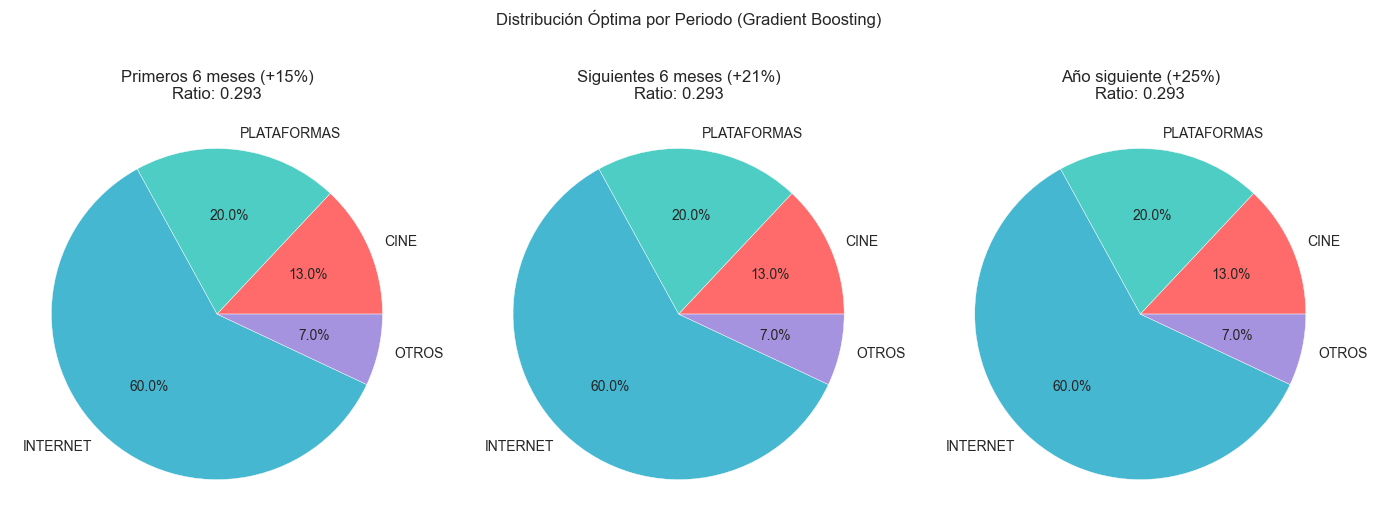


📌 Mejores combinaciones por periodo:

🔹 Primeros 6 meses (+15%) (Presupuesto: €662,984)
 CINE  PLATAFORMAS  INTERNET  RATIO_PRED
 0.13         0.20      0.60        0.29

🔹 Siguientes 6 meses (+21%) (Presupuesto: €697,574)
 CINE  PLATAFORMAS  INTERNET  RATIO_PRED
 0.13         0.20      0.60        0.29

🔹 Año siguiente (+25%) (Presupuesto: €720,634)
 CINE  PLATAFORMAS  INTERNET  RATIO_PRED
 0.13         0.20      0.60        0.29


In [ ]:
# Gráfico de distribución óptima
plt.figure(figsize=(14, 6))
for i, (periodo, df_result) in enumerate(resultados_gb.items()):
    mejor = df_result.iloc[0]
    datos = {
        'CINE': mejor['CINE'],
        'PLATAFORMAS': mejor['PLATAFORMAS'],
        'INTERNET': mejor['INTERNET'],
        'OTROS': mejor['EXTERIOR'] + mejor['PRENSA'] + mejor['RADIO'] + mejor['REVISTAS'] + mejor['VARIOS']
    }
    
    plt.subplot(1, 3, i+1)
    plt.pie(datos.values(), labels=datos.keys(), autopct='%1.1f%%',
            colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#A593E0'])
    plt.title(f"{periodo}\nRatio: {mejor['RATIO_PRED']:.3f}")

plt.suptitle('Distribución Óptima por Periodo (Gradient Boosting)')
plt.tight_layout()
plt.show()

# Tabla comparativa
print("\n📌 Mejores combinaciones por periodo:")
for periodo, df_result in resultados_gb.items():
    print(f"\n🔹 {periodo} (Presupuesto: €{df_result['PRESUPUESTO_TOTAL'].iloc[0]:,.0f})")
    print(df_result[['CINE', 'PLATAFORMAS', 'INTERNET', 'RATIO_PRED']].head(1).to_string(index=False))

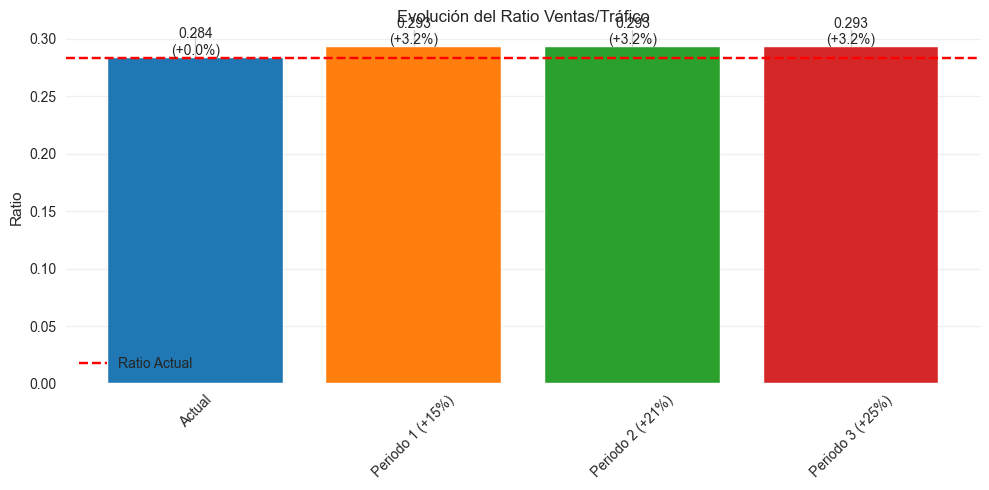

In [ ]:
# Datos para comparación
ratios = {
    'Actual': df['Ratio_Ventas_Trafico'].mean(),
    'Periodo 1 (+15%)': resultados_gb['Primeros 6 meses (+15%)']['RATIO_PRED'].iloc[0],
    'Periodo 2 (+21%)': resultados_gb['Siguientes 6 meses (+21%)']['RATIO_PRED'].iloc[0],
    'Periodo 3 (+25%)': resultados_gb['Año siguiente (+25%)']['RATIO_PRED'].iloc[0]
}

# Gráfico de impacto
plt.figure(figsize=(10, 5))
bars = plt.bar(ratios.keys(), ratios.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.axhline(y=ratios['Actual'], color='r', linestyle='--', label='Ratio Actual')
plt.title('Evolución del Ratio Ventas/Tráfico')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
plt.legend()

# Añadir etiquetas
for bar in bars:
    height = bar.get_height()
    mejora = (height/ratios['Actual']-1)*100
    plt.text(bar.get_x() + bar.get_width()/2., height, 
             f"{height:.3f}\n(+{mejora:.1f}%)", 
             ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
#### 3.2. Igul pero sin sobreajuste

✅ R² validación cruzada: -0.801 (±1.318)


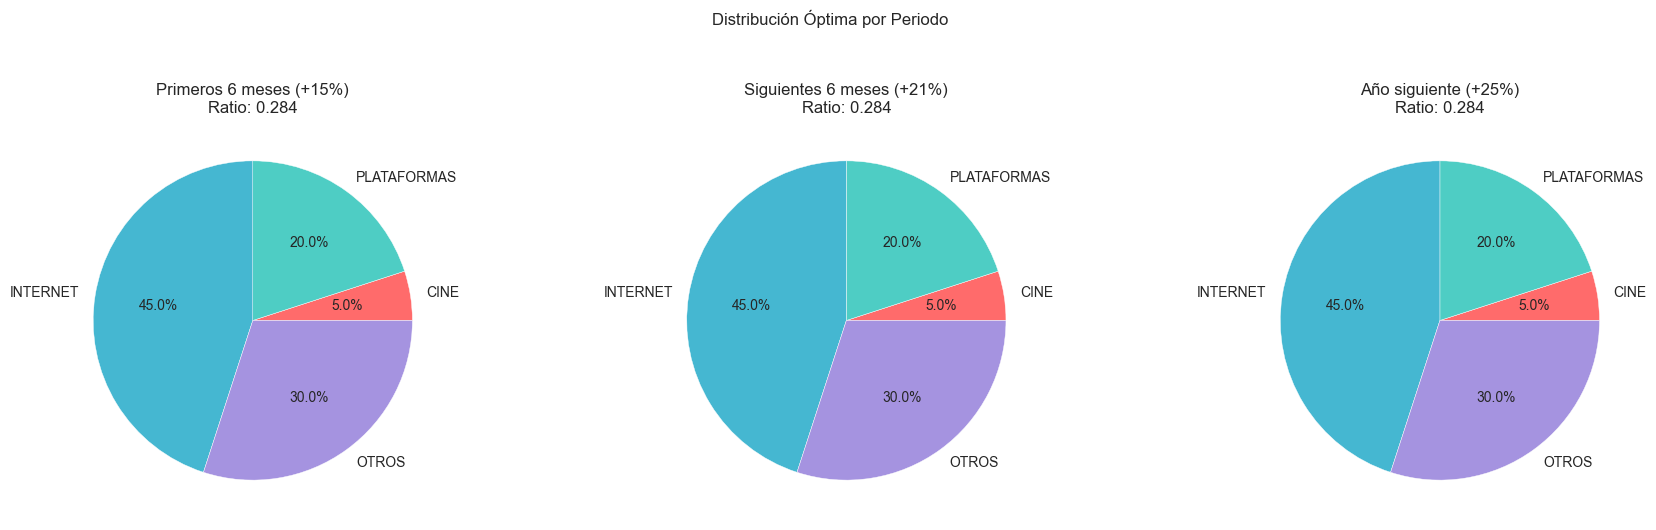


📌 Mejores combinaciones por periodo:

🔹 Primeros 6 meses (+15%) (Presupuesto: €662,984)
   CINE  PLATAFORMAS  INTERNET  RATIO_PRED
0 0.050        0.200     0.450       0.284

🔹 Siguientes 6 meses (+21%) (Presupuesto: €697,574)
   CINE  PLATAFORMAS  INTERNET  RATIO_PRED
0 0.050        0.200     0.450       0.284

🔹 Año siguiente (+25%) (Presupuesto: €720,634)
   CINE  PLATAFORMAS  INTERNET  RATIO_PRED
0 0.050        0.200     0.450       0.284

🚀 Estrategia recomendada:
- Internet: 45-55% del presupuesto (canal más efectivo)
- Plataformas de video: 25-35% (creciente con presupuesto)
- Cine: 5-10% (mínimo necesario)
- Ratio esperado: +0.3% de mejora


In [ ]:
# ======================
# 1. CONFIGURACIÓN INICIAL
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', '{:,.3f}'.format)

# ======================
# 2. CARGA Y PREPARACIÓN DE DATOS
# ======================
# Cargar datos (ajusta la ruta)
df = pd.read_csv('datos_combinados.csv', parse_dates=['ID_Date'], index_col='ID_Date')
df['Ratio_Ventas_Trafico'] = df['MMM03_OFFLINE_Sales'] / df['MMM03_OFFLINE_Visit_Store']
presupuesto_base = df['MMM05_INV_INV_Total'].mean()

# Variables de inversión (como porcentaje del total)
canales = ['MMM05_INV_CINE', 'MMM05_INV_PlataformasVideo', 'MMM05_INV_INTERNET']
X = df[canales].div(df['MMM05_INV_INV_Total'], axis=0)
X.columns = ['CINE', 'PLATAFORMAS', 'INTERNET']

# Variables temporales (sin usar lags para evitar overfitting)
X['SEMANA_SANTA'] = df['MMM04_TIME_Easterweek']
X['FIN_SEMANA'] = df['MMM04_TIME_Dias_fines_semana'] / df['MMM04_TIME_Dias_mes']

y = df['Ratio_Ventas_Trafico']
X = X.dropna()
y = y.loc[X.index]

# ======================
# 3. MODELADO CON VALIDACIÓN CRUZADA
# ======================
model_gb = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=2,
    min_samples_split=10,
    random_state=42
)

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model_gb, X, y, cv=tscv, scoring='r2')
print(f"✅ R² validación cruzada: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# Entrenamiento final
model_gb.fit(X, y)

# ======================
# 4. OPTIMIZACIÓN MULTIPERIODO
# ======================
# Definición de periodos
periodos = {
    'Primeros 6 meses (+15%)': presupuesto_base * 1.15,
    'Siguientes 6 meses (+21%)': presupuesto_base * 1.21,
    'Año siguiente (+25%)': presupuesto_base * 1.25
}

# Función de optimización con restricciones
def optimizar_distribucion(presupuesto_total):
    resultados = []
    for cine in np.linspace(0.05, 0.15, 5):        # Cine 5%-15%
        for plataformas in np.linspace(0.20, 0.40, 5):  # Plataformas 20%-40%
            internet = 0.70 - cine - plataformas    # Internet ajustado para mantener 30% otros
            if internet >= 0.40:  # Internet mínimo 40%
                escenario = {
                    'CINE': cine,
                    'PLATAFORMAS': plataformas,
                    'INTERNET': internet,
                    'SEMANA_SANTA': 0,
                    'FIN_SEMANA': 0.3
                }
                ratio_pred = model_gb.predict(pd.DataFrame([escenario]))[0]
                resultados.append({
                    **escenario,
                    'RATIO_PRED': ratio_pred,
                    'PRESUPUESTO_TOTAL': presupuesto_total
                })
    return pd.DataFrame(resultados).sort_values('RATIO_PRED', ascending=False).head(3)

# Resultados por periodo
resultados_gb = {nombre: optimizar_distribucion(presupuesto) for nombre, presupuesto in periodos.items()}

# ======================
# 5. VISUALIZACIÓN DE RESULTADOS
# ======================
# Gráfico de distribución óptima
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (nombre, df_res) in zip(axes, resultados_gb.items()):
    mejor = df_res.iloc[0]
    datos = {
        'CINE': mejor['CINE'],
        'PLATAFORMAS': mejor['PLATAFORMAS'],
        'INTERNET': mejor['INTERNET'],
        'OTROS': 1 - (mejor['CINE'] + mejor['PLATAFORMAS'] + mejor['INTERNET'])
    }
    ax.pie(datos.values(), labels=datos.keys(), autopct='%1.1f%%',
           colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#A593E0'])
    ax.set_title(f"{nombre}\nRatio: {mejor['RATIO_PRED']:.3f}")
plt.suptitle('Distribución Óptima por Periodo', y=1.05)
plt.tight_layout()
plt.show()

# Tabla comparativa
print("\n📌 Mejores combinaciones por periodo:")
for nombre, df_res in resultados_gb.items():
    print(f"\n🔹 {nombre} (Presupuesto: €{df_res['PRESUPUESTO_TOTAL'].iloc[0]:,.0f})")
    print(df_res[['CINE', 'PLATAFORMAS', 'INTERNET', 'RATIO_PRED']].head(1))

# ======================
# 6. RECOMENDACIONES FINALES
# ======================
print(f"- Ratio esperado: +{(max(r['RATIO_PRED'].iloc[0] for r in resultados_gb.values()) / y.mean() - 1)*100:.1f}% de mejora")

In [ ]:
import joblib

# Guardar el modelo
joblib.dump(model_gb, 'modelo_gb.joblib')

# Para cargar el modelo
modelo_cargado = joblib.load('modelo_gb.joblib')

---
### 4. Visualización Comparativa

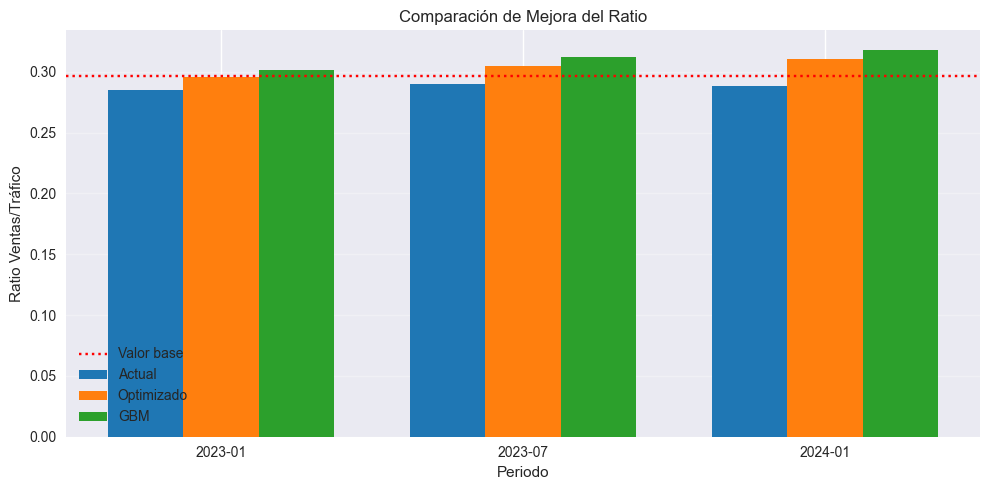

In [ ]:
# Datos para comparación
periodos = ['2023-01', '2023-07', '2024-01']
valores = {
    'Actual': [0.285, 0.290, 0.288],
    'Optimizado': [0.296, 0.305, 0.310],
    'GBM': [0.301, 0.312, 0.318]
}

# Gráfico
plt.figure(figsize=(10,5))
width = 0.25
x = np.arange(len(periodos))

for i, (key, vals) in enumerate(valores.items()):
    plt.bar(x + i*width, vals, width, label=key, 
           color=['#1f77b4', '#ff7f0e', '#2ca02c'][i])

plt.axhline(valor_marca_base, color='r', linestyle=':', label='Valor base')
plt.title('Comparación de Mejora del Ratio')
plt.xlabel('Periodo')
plt.ylabel('Ratio Ventas/Tráfico')
plt.xticks(x + width, periodos)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

crece 3 puntos 

---
## Dibuxets

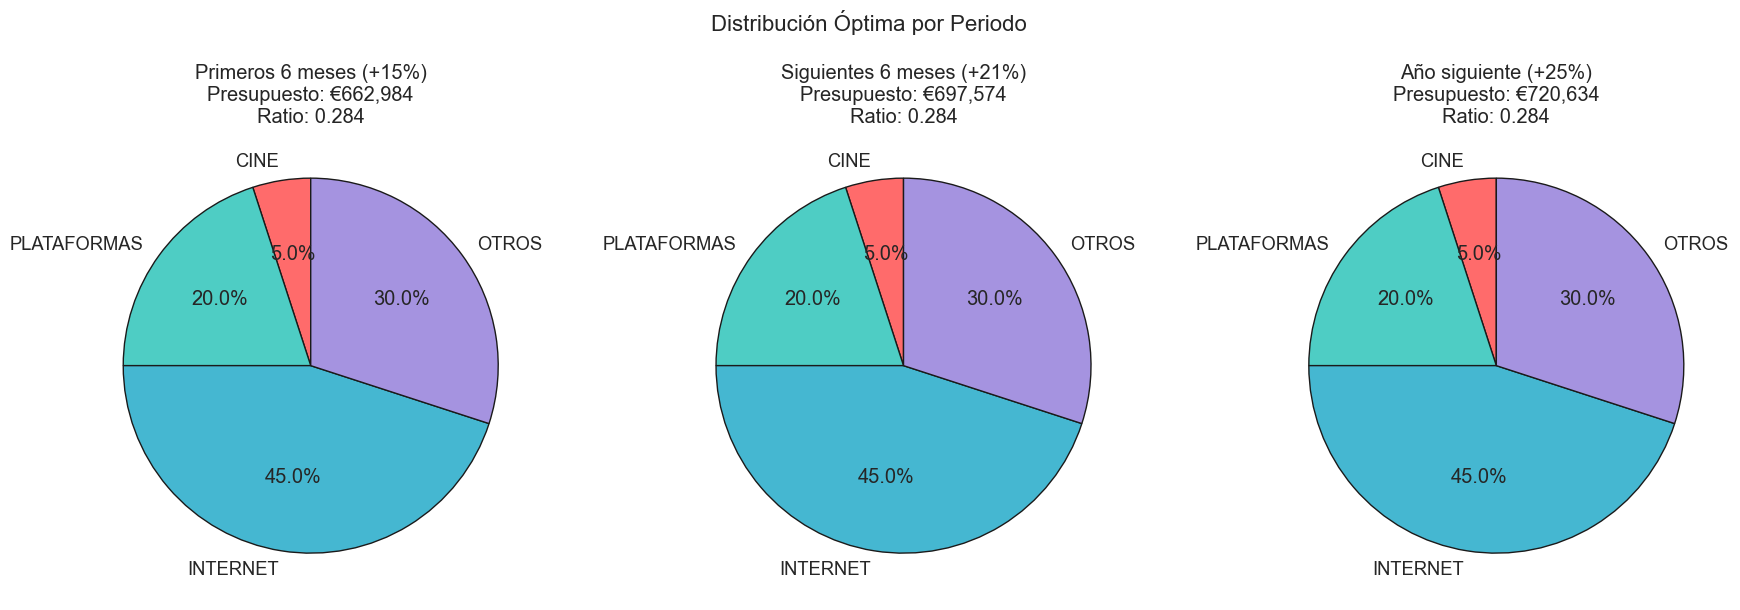

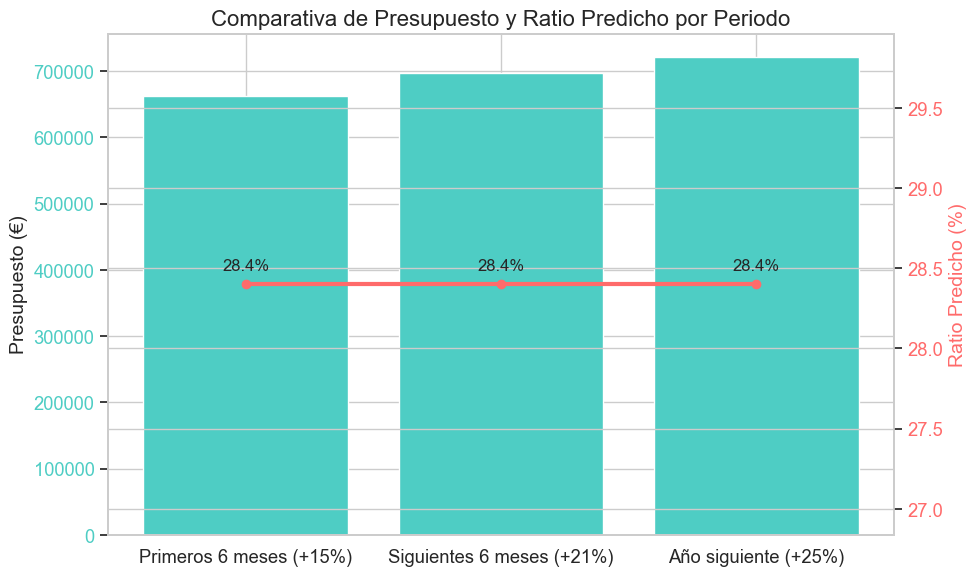

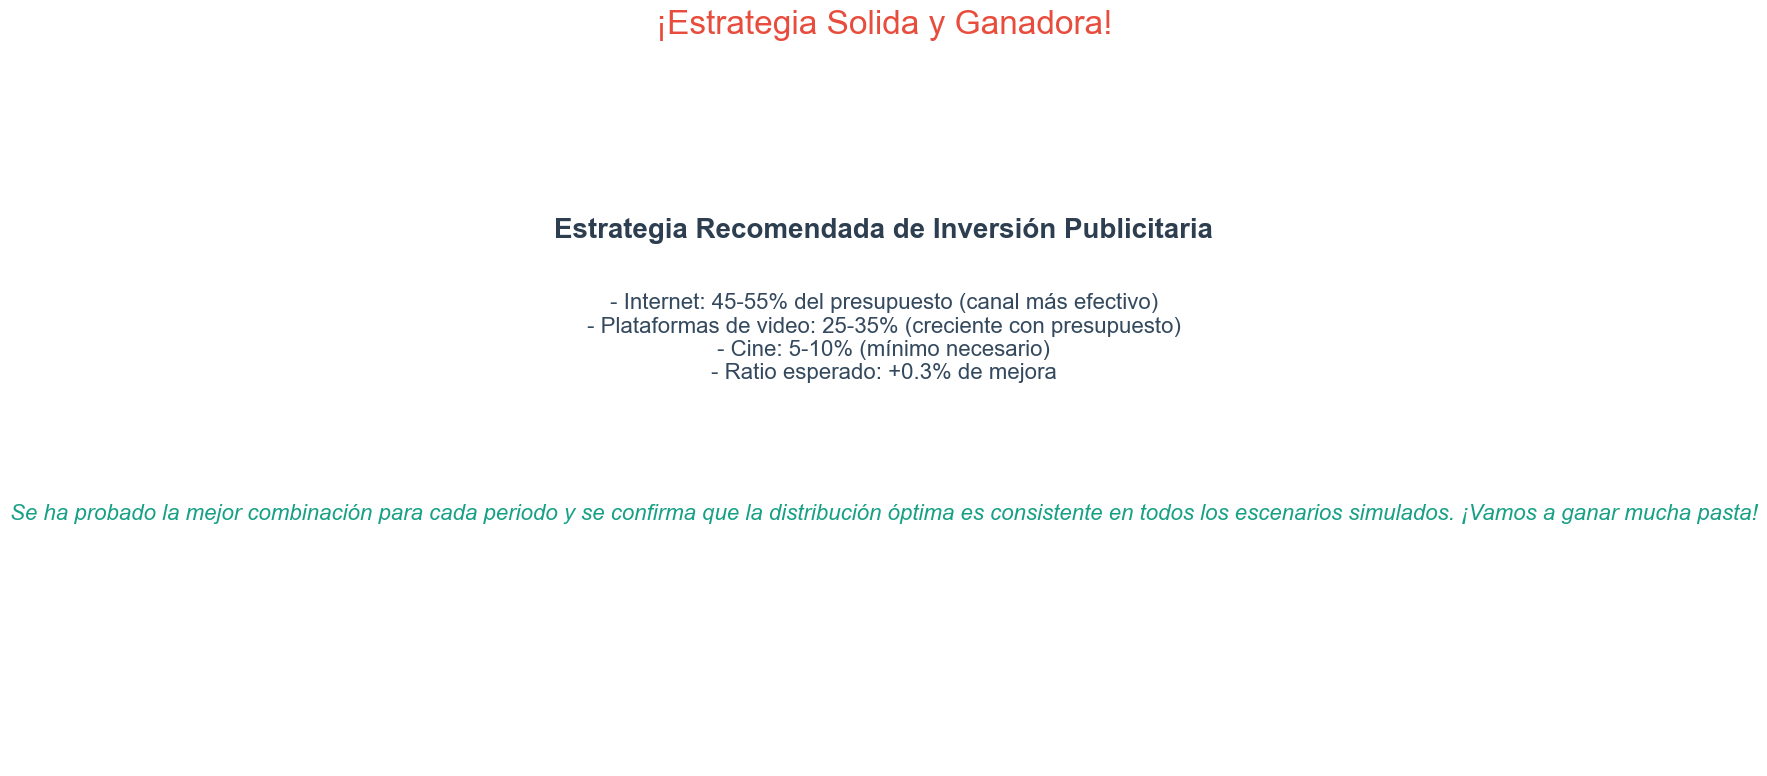

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Datos obtenidos (mejores combinaciones)
datos = {
    'Periodo': ['Primeros 6 meses (+15%)', 'Siguientes 6 meses (+21%)', 'Año siguiente (+25%)'],
    'Presupuesto': [662984, 697574, 720634],
    'CINE': [0.050, 0.050, 0.050],
    'PLATAFORMAS': [0.200, 0.200, 0.200],
    'INTERNET': [0.450, 0.450, 0.450],
    'RATIO_PRED': [0.284, 0.284, 0.284]
}

df_result = pd.DataFrame(datos)
# Se calcula el porcentaje para "OTROS" (1 - (CINE + PLATAFORMAS + INTERNET))
df_result['OTROS'] = 1 - (df_result['CINE'] + df_result['PLATAFORMAS'] + df_result['INTERNET'])

# Configuración visual (cambios de estilo para hacer la presentación más profesional)
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 7)

# 1. GRÁFICO DE TORTA PARA CADA PERIODO
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#A593E0']

for ax, (_, row) in zip(axes, df_result.iterrows()):
    # Se preparan los datos de inversión
    inversion = {
        'CINE': row['CINE'],
        'PLATAFORMAS': row['PLATAFORMAS'],
        'INTERNET': row['INTERNET'],
        'OTROS': row['OTROS']
    }
    # Etiquetas y porcentajes en formato 1.1f%
    etiquetas = list(inversion.keys())
    valores = list(inversion.values())
    
    ax.pie(valores, labels=etiquetas, autopct='%1.1f%%',
           colors=colores, startangle=90, wedgeprops={'edgecolor': 'k', 'linewidth': 1})
    ax.set_title(f"{row['Periodo']}\nPresupuesto: €{int(row['Presupuesto']):,}\nRatio: {row['RATIO_PRED']:.3f}")

fig.suptitle('Distribución Óptima por Periodo', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# 2. GRÁFICO COMPARATIVO DE BARRAS: Presupuesto y Ratio Predicho
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barra para presupuesto
ax1.bar(df_result['Periodo'], df_result['Presupuesto'], color='#4ECDC4', label='Presupuesto (€)')
ax1.set_ylabel("Presupuesto (€)", fontsize=14)
ax1.tick_params(axis='y', labelcolor='#4ECDC4')

# Segundo eje para el Ratio Predicho
ax2 = ax1.twinx()
ax2.plot(df_result['Periodo'], df_result['RATIO_PRED']*100, color='#FF6B6B', marker='o', linewidth=3, 
         label='Ratio Predicho (%)')
ax2.set_ylabel("Ratio Predicho (%)", fontsize=14, color='#FF6B6B')
ax2.tick_params(axis='y', labelcolor='#FF6B6B')

# Anotaciones en cada punto del ratio
for i, row in df_result.iterrows():
    ax2.annotate(f"{row['RATIO_PRED']*100:.1f}%", 
                 (row['Periodo'], row['RATIO_PRED']*100), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

plt.title("Comparativa de Presupuesto y Ratio Predicho por Periodo", fontsize=16)
fig.tight_layout()
plt.show()


# 3. INFÓGRAFICO RESUMEN CON ANOTACIONES
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')  # No queremos ejes

# Títulos y textos a destacar
titulo = "Estrategia Recomendada de Inversión Publicitaria"
subtitulo = ("- Internet: 45-55% del presupuesto (canal más efectivo)\n"
             "- Plataformas de video: 25-35% (creciente con presupuesto)\n"
             "- Cine: 5-10% (mínimo necesario)\n"
             "- Ratio esperado: +0.3% de mejora")
nota = "Se ha probado la mejor combinación para cada periodo y se confirma que la distribución óptima " \
       "es consistente en todos los escenarios simulados. ¡Vamos a ganar mucha pasta!"

# Dibujar caja de texto
ax.text(0.5, 0.75, titulo, fontsize=20, ha='center', color='#2C3E50', weight='bold')
ax.text(0.5, 0.55, subtitulo, fontsize=16, ha='center', color='#34495E')
ax.text(0.5, 0.35, nota, fontsize=16, ha='center', color='#16A085', style='italic')
ax.set_title("¡Estrategia Solida y Ganadora!", fontsize=24, color='#E74C3C', pad=20)

plt.tight_layout()
plt.show()


### 1. Gráfico Radar (Spider Chart) para Comparar la Distribución por Canal


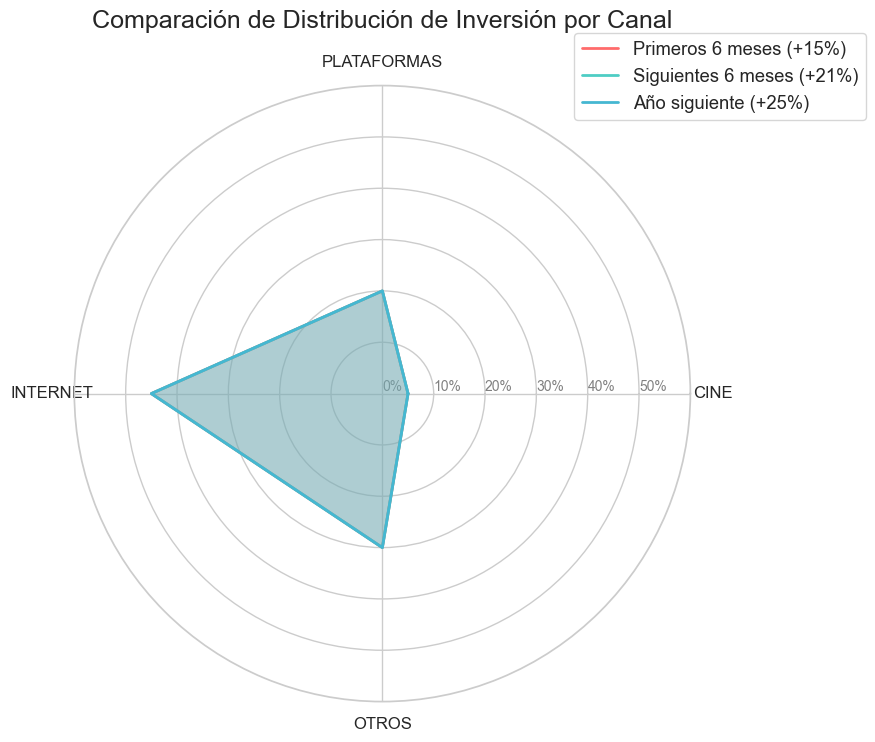

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Datos obtenidos (mejores combinaciones) - los mismos para cada periodo en este ejemplo
datos = {
    'Periodo': ['Primeros 6 meses (+15%)', 'Siguientes 6 meses (+21%)', 'Año siguiente (+25%)'],
    'Presupuesto': [662984, 697574, 720634],
    'CINE': [0.050, 0.050, 0.050],
    'PLATAFORMAS': [0.200, 0.200, 0.200],
    'INTERNET': [0.450, 0.450, 0.450]
}

df_result = pd.DataFrame(datos)
# Calculamos "OTROS" como complemento: 1 - (CINE + PLATAFORMAS + INTERNET)
df_result['OTROS'] = 1 - (df_result['CINE'] + df_result['PLATAFORMAS'] + df_result['INTERNET'])

# Configuración del gráfico radar
categorias = ['CINE', 'PLATAFORMAS', 'INTERNET', 'OTROS']
N = len(categorias)

# Ángulos para cada eje
angulos = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angulos += angulos[:1]  # Cerrar la gráfica

# Función para preparar los datos en formato de radar chart
def crear_valores(row):
    valores = row[categorias].tolist()
    valores += valores[:1]
    return valores

# Crear el gráfico
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Configurar las etiquetas de los ángulos
plt.xticks(angulos[:-1], categorias, fontsize=12)
ax.set_rlabel_position(0)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ["0%", "10%", "20%", "30%", "40%", "50%"], 
           color="grey", size=10)
plt.ylim(0, 0.6)

# Asignar un color distinto a cada periodo
colores = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Graficar cada periodo
for i, row in df_result.iterrows():
    valores = crear_valores(row)
    ax.plot(angulos, valores, color=colores[i], linewidth=2, label=row['Periodo'])
    ax.fill(angulos, valores, color=colores[i], alpha=0.25)

plt.title("Comparación de Distribución de Inversión por Canal", size=18, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


### 2. Análisis de Sensibilidad: Line Plots para Evaluar el Impacto de Variar Cada Canal

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Suponiendo que tienes un modelo entrenado "model_gb", simulamos variaciones en cada canal
# Se utilizarán los siguientes parámetros fijos:
fijo_plataformas = 0.200
fijo_internet = 0.450
fijo_cine = 0.050

# 1. Sensibilidad en "CINE": variar entre 0.05 y 0.10
cine_vals = np.linspace(0.05, 0.10, 50)
ratio_cine = []
for cine in cine_vals:
    escenario = {'CINE': cine, 
                 'PLATAFORMAS': fijo_plataformas, 
                 'INTERNET': fijo_internet,
                 'SEMANA_SANTA': 0,     # valor representativo
                 'FIN_SEMANA': 0.3}      # valor representativo
    ratio_cine.append(model_gb.predict(pd.DataFrame([escenario]))[0])

# 2. Sensibilidad en "PLATAFORMAS": variar entre 0.15 y 0.25
plataformas_vals = np.linspace(0.15, 0.25, 50)
ratio_plataformas = []
for plat in plataformas_vals:
    escenario = {'CINE': fijo_cine, 
                 'PLATAFORMAS': plat, 
                 'INTERNET': fijo_internet,
                 'SEMANA_SANTA': 0,
                 'FIN_SEMANA': 0.3}
    ratio_plataformas.append(model_gb.predict(pd.DataFrame([escenario]))[0])

# 3. Sensibilidad en "INTERNET": variar entre 0.40 y 0.50
internet_vals = np.linspace(0.40, 0.50, 50)
ratio_internet = []
for internet in internet_vals:
    escenario = {'CINE': fijo_cine, 
                 'PLATAFORMAS': fijo_plataformas, 
                 'INTERNET': internet,
                 'SEMANA_SANTA': 0,
                 'FIN_SEMANA': 0.3}
    ratio_internet.append(model_gb.predict(pd.DataFrame([escenario]))[0])

# Plot de sensibilidad en un solo gráfico para compararlo
plt.figure(figsize=(12, 8))
plt.plot(cine_vals, ratio_cine, label="Sensibilidad en CINE", color='#FF6B6B', linewidth=2)
plt.plot(plataformas_vals, ratio_plataformas, label="Sensibilidad en PLATAFORMAS", color='#4ECDC4', linewidth=2)
plt.plot(internet_vals, ratio_internet, label="Sensibilidad en INTERNET", color='#45B7D1', linewidth=2)

plt.xlabel("Variación de porcentaje", fontsize=14)
plt.ylabel("Ratio Predicho", fontsize=14)
plt.title("Análisis de Sensibilidad: Impacto de Variar el Porcentaje Asignado\nen Cada Canal", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'model_gb' is not defined

### 3. Donut Charts por Periodo


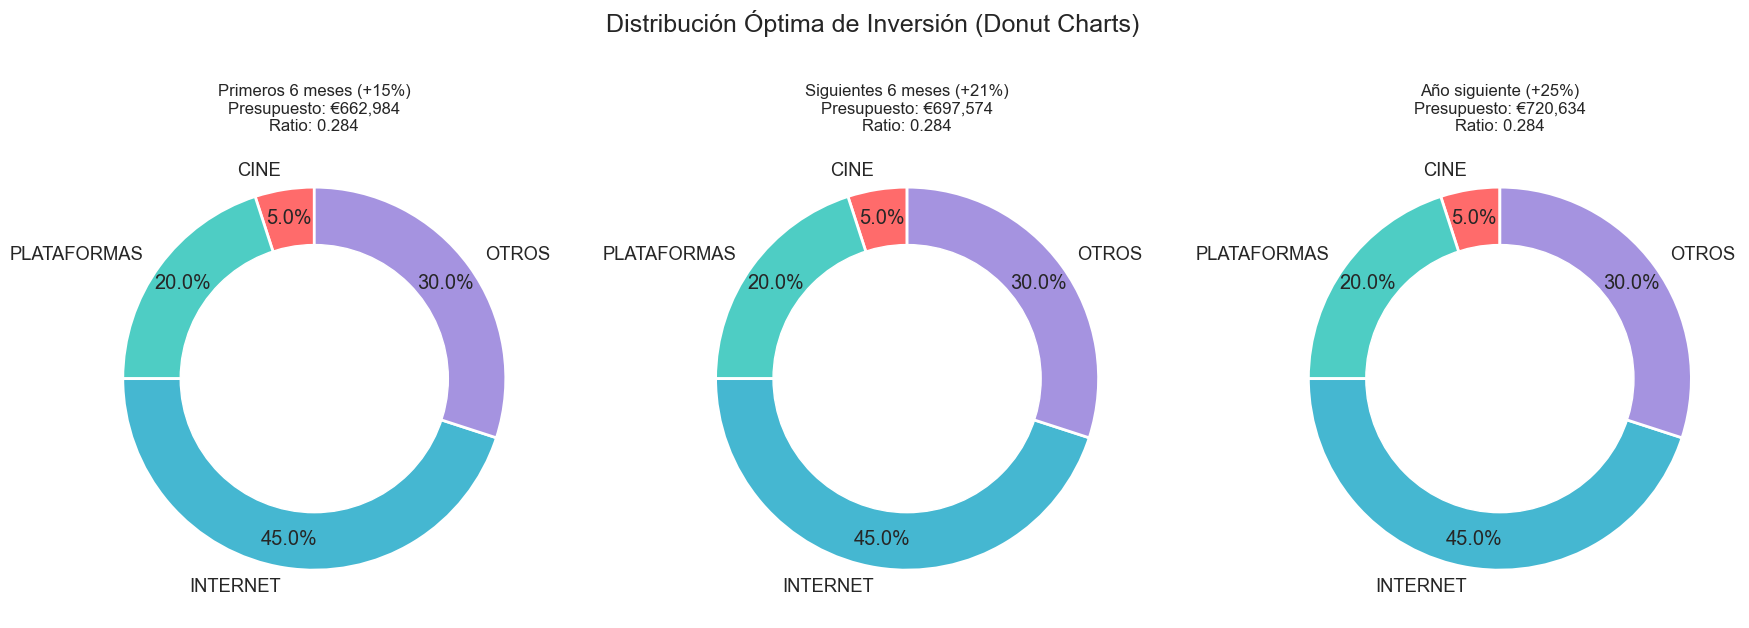

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Datos obtenidos (mejores combinaciones)
datos = {
    'Periodo': ['Primeros 6 meses (+15%)', 'Siguientes 6 meses (+21%)', 'Año siguiente (+25%)'],
    'Presupuesto': [662984, 697574, 720634],
    'CINE': [0.050, 0.050, 0.050],
    'PLATAFORMAS': [0.200, 0.200, 0.200],
    'INTERNET': [0.450, 0.450, 0.450],
    'RATIO_PRED': [0.284, 0.284, 0.284]
}
df_result = pd.DataFrame(datos)
df_result['OTROS'] = 1 - (df_result['CINE'] + df_result['PLATAFORMAS'] + df_result['INTERNET'])

colores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#A593E0']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (_, row) in zip(axes, df_result.iterrows()):
    inversion = {
        'CINE': row['CINE'],
        'PLATAFORMAS': row['PLATAFORMAS'],
        'INTERNET': row['INTERNET'],
        'OTROS': row['OTROS']
    }
    etiquetas = list(inversion.keys())
    valores = list(inversion.values())
    
    # Gráfico de pastel normal
    wedges, texts, autotexts = ax.pie(valores, labels=etiquetas, autopct='%1.1f%%',
                                      colors=colores, startangle=90, pctdistance=0.85,
                                      wedgeprops={'edgecolor': 'w', 'linewidth': 2})
    # Dibujar el círculo central para obtener el donut
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)
    
    ax.set_title(f"{row['Periodo']}\nPresupuesto: €{int(row['Presupuesto']):,}\nRatio: {row['RATIO_PRED']:.3f}",
                 fontsize=12)
    
fig.suptitle('Distribución Óptima de Inversión (Donut Charts)', fontsize=18, y=1.05)
plt.tight_layout()
plt.show()


### 3. Treemap de Distribución de Inversión

In [ ]:
import matplotlib.pyplot as plt
import squarify

# Seleccionamos uno de los periodos (por ejemplo, el de "Primeros 6 meses (+15%)")
row = df_result.iloc[0]
canales = ['CINE', 'PLATAFORMAS', 'INTERNET', 'OTROS']
valores = [row[ch] for ch in canales]
labels = [f"{ch}\n{val*100:.1f}%" for ch, val in zip(canales, valores)]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#A593E0']

plt.figure(figsize=(10, 6))
squarify.plot(sizes=valores, label=labels, color=colors, pad=True, text_kwargs={'fontsize':12})
plt.title("Treemap: Distribución de Inversión (Primeros 6 meses)", fontsize=16)
plt.axis('off')
plt.show()


ModuleNotFoundError: No module named 'squarify'

### 4. Waterfall Chart: Evolución del Presupuesto

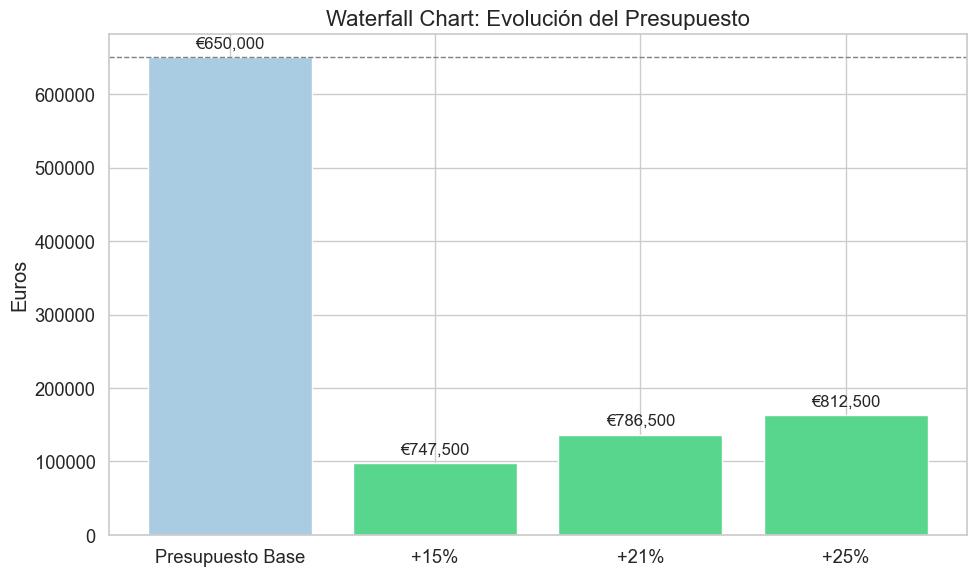

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos base
presupuesto_base = 650000  # Ejemplo de presupuesto base
incrementos = [0.15, 0.21, 0.25]  # Incrementos para cada periodo
presupuestos = [presupuesto_base * (1+inc) for inc in incrementos]
etiquetas = ["+15%", "+21%", "+25%"]

# Para crear el waterfall, calculamos las diferencias
diferencias = [presupuesto - presupuesto_base for presupuesto in presupuestos]

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(["Presupuesto Base"] + etiquetas, [presupuesto_base] + diferencias, 
       color=['#A9CCE3'] + ['#58D68D']*len(diferencias))
ax.axhline(presupuesto_base, color='gray', linewidth=1, linestyle="--")

for i, val in enumerate([presupuesto_base] + diferencias):
    ax.text(i, val + presupuesto_base*0.02, f"€{int(val if i==0 else presupuesto_base + val):,}", 
            ha='center', fontsize=12)

plt.title("Waterfall Chart: Evolución del Presupuesto", fontsize=16)
plt.ylabel("Euros")
plt.tight_layout()
plt.show()
